# GMVAE

This notebook attempts to implement the GMVAE which assumes the latent of a VAE is sampled from
- Sampled data can take $k$ different classes $\mathcal{C}=\{1,2,\dots,k\}$.
- The prior is modeled by two latent components $c\in\mathcal{C}$ and $\mathbf{z}\in\R^s$ instead of just $\mathbf{z}$
- Given $p(c;\theta)\sim\text{Categorical}(\mathcal{C})$ (assumed to be of equal probability) and $p(\mathbf{z}_1;\theta)\sim\mathbf{N}(\mathbf{0},\mathbf{I_s})$, we model $\mathbf{z}_2$ as a Gaussian Mixture Model where the class weights are $p(c;\theta)$ with means $\mu_\theta(\mathbf{z}_1)$ and covariances $\text{diag}(\sigma^2_\theta(\mathbf{z}_1))$ conditioned on $\mathbf{z}_1$, that is, $\mathbf{z}_2|\mathbf{z}_1,c$ is a Gaussian Mixture Model.
- Likewise, we aim to learn $p(\mathbf{x},\mathbf{z}_1,c,\mathbf{z}_2;\theta)$ and the corresponding $q(\mathbf{z}_1,c,\mathbf{z}_2|\mathbf{x};\phi)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from tqdm import tqdm
import torchvision
import torchvision.datasets as datasets
import math

#for consistency, all seeds are set to 69420
seed = 69420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

use MNIST as always

<Figure size 640x480 with 0 Axes>

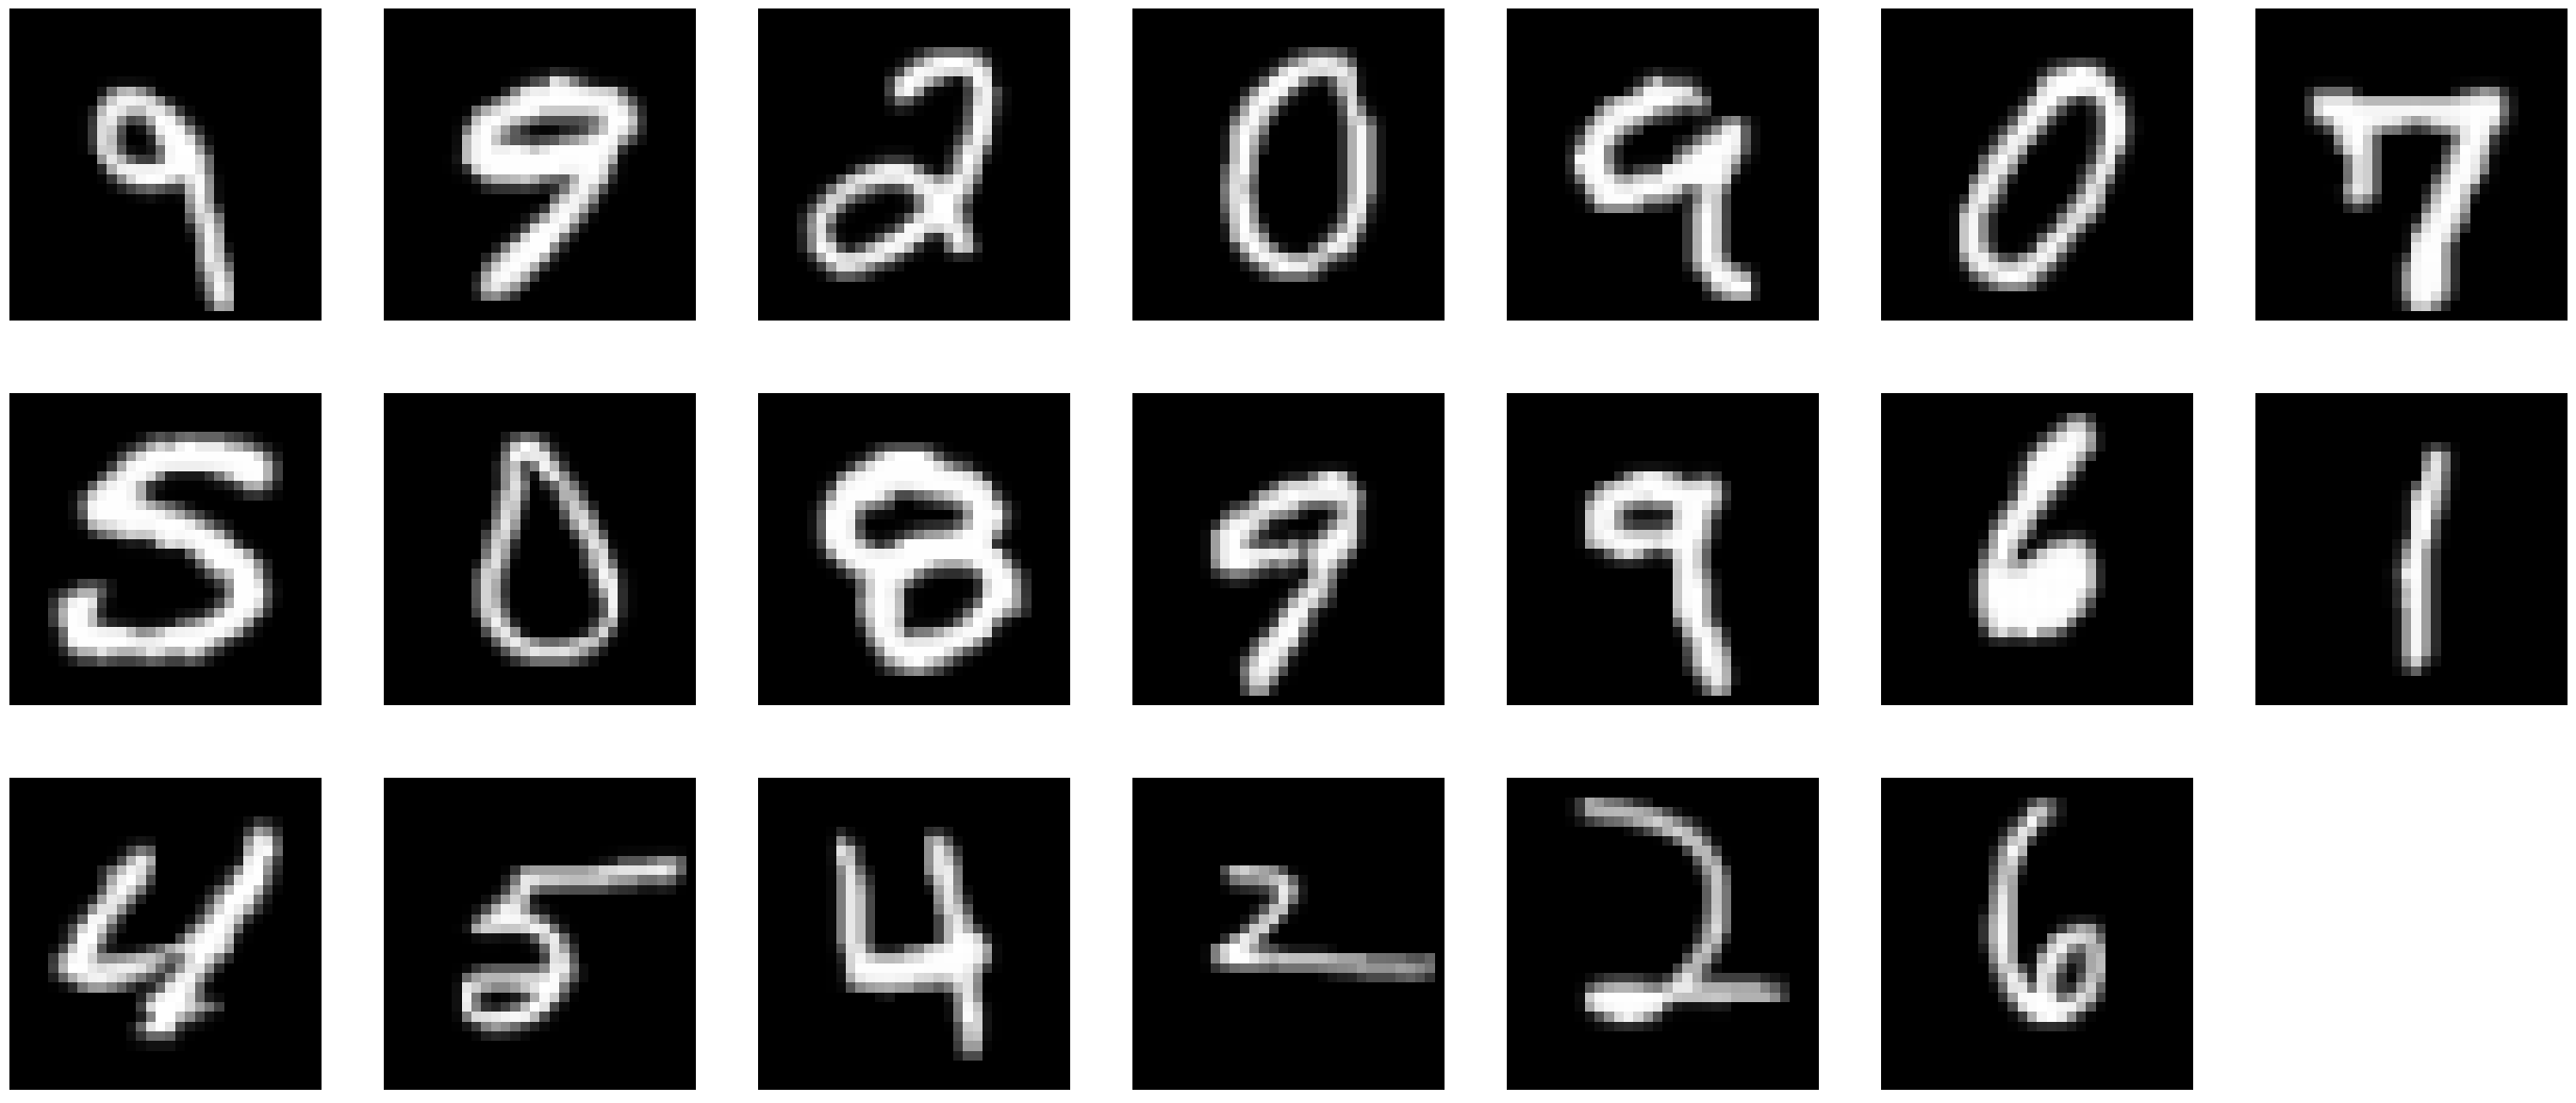

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
data_loader = torch.utils.data.DataLoader(mnist_trainset,batch_size=128,shuffle=True,num_workers=1)

plt.gray()

def plotter(images):
    f = -(-len(images)//3)
    fig,ax = plt.subplots(3,f,figsize=(5*f, 15))
    for i in range(len(images)):
        ax[i%3,i//3].imshow(images[i,0])
    for aa in ax:
        for aaa in aa:
            aaa.axis("off")
    plt.show()

for a, b in data_loader:
    plotter(a[0:20])
    break


## Encoder

The encoder follows this KL divergence formulation by the authors

\begin{align*}
    \mathrm{ELBO}(\mathbf{x},\theta,\phi)
    &= \mathbb{E}_{c \sim q(c \mid \mathbf{x}; \phi)}\bigl[\log p(\mathbf{x} \mid c; \theta)\bigr] \\[6pt]
    &\quad
    - \mathbb{E}_{\mathbf{z}_1,\,c \sim q(\mathbf{z}_1 \mid \mathbf{x}; \phi)\,p(c \mid \mathbf{z}_2,\mathbf{z}_1; \theta)}
    \bigl[D_{\mathrm{KL}}\bigl(q(c \mid \mathbf{z}_2,\mathbf{x}; \phi),\,p(c \mid \mathbf{z}_2,\mathbf{z}_1; \theta)\bigr)\bigr] \\[6pt]
    &\quad
    - D_{\mathrm{KL}}\bigl(q(\mathbf{z}_1 \mid \mathbf{x}; \phi),\,p(\mathbf{z}_1)\bigr) \\[6pt]
    &\quad
    - \mathbb{E}_{c,\,\mathbf{z}_1 \sim q(c \mid \mathbf{x}; \phi)\,q(\mathbf{z}_1 \mid \mathbf{x}; \phi)}
    \bigl[D_{\mathrm{KL}}\bigl(p(c \mid \mathbf{z}_2,\mathbf{z}_1; \theta),\,p(c \mid \mathbf{z}_2; \theta)\bigr)\bigr]
\end{align*}

basically the classes $c$ are not given but rather inferred from the other components

In [3]:
class Encoder(nn.Module):
    def __init__(self, z1_dim, z2_dim, img_channel, n_components):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # q(z1 | x) parameters
        self.mu_z1_fc = nn.Conv2d(256, z1_dim, 2, 1, 0, bias=False) #mu(x)
        self.var_z1_fc = nn.Conv2d(256, z1_dim, 2, 1, 0, bias=False) #sigma(x)

        # q(z2 | x) parameters
        self.mu_z2_fc = nn.Conv2d(256, z2_dim, 2, 1, 0, bias=False)
        self.var_z2_fc = nn.Conv2d(256, z2_dim, 2, 1, 0, bias=False)

        # p(z2 | z1), produces a mixture of gaussians
        self.z2_comp_mu = nn.Linear(z1_dim, n_components*z2_dim)
        self.z2_comp_var = nn.Linear(z1_dim, n_components*z2_dim)

        self.n_components = n_components
        self.z2_dim = z2_dim
        
        self.kl_z1, self.kl_z2c, self.kl_c = None, None, None

    def forward(self, x, normal_generator, temperature=1.0):
        B = x.shape[0]
        K = self.n_components
        D = self.z2_dim
        encoded = self.encoder(x)
        
        # step 1: z1~q(z1|x)
        mu_z1 = self.mu_z1_fc(encoded).mean([-2,-1])
        sigma_z1 = torch.exp(self.var_z1_fc(encoded)).mean([-2,-1])
        z1 = mu_z1 + sigma_z1*normal_generator.sample(mu_z1.shape)

        # step 2: z2~p(z2|z1)
        component_mu = self.z2_comp_mu(z1).reshape(B, self.n_components, self.z2_dim)
        component_sigma = torch.exp(self.z2_comp_var(z1)).reshape(B, self.n_components, self.z2_dim)
        
        # step 3: z2~q(x2|x)
        mu_z2 = self.mu_z2_fc(encoded).mean([-2,-1])
        sigma_z2 = torch.exp(self.var_z2_fc(encoded)).mean([-2,-1])
        z2 = mu_z2 + sigma_z2*normal_generator.sample(mu_z2.shape)

        # step 4: c~p(c|z2,z1)
        log_prob_k = -0.5*(
            ((z2.unsqueeze(1)-component_mu)**2) / (component_sigma**2)
            + 2*torch.log(component_sigma)
            + math.log(2*math.pi)
        ).sum(-1)
        log_pi = math.log(1.0 / self.n_components) # assume c starts of equal/uniform
        logits_c = log_pi + log_prob_k
        c_onehot = torch.nn.functional.gumbel_softmax(logits_c, tau=temperature, hard=True)
        
        # step 5: compute KL losses
        kl_z1 = 0.5*torch.sum(sigma_z1**2+mu_z1**2-2*torch.log(sigma_z1)-1)
        kl_z2c = 0.5 * torch.sum(
            c_onehot.unsqueeze(-1) * (
                2 * torch.log(component_sigma)  # log det z2_sigma from p
                - 2 * torch.log(sigma_z2).unsqueeze(1)  # log det z2_sigma from q
                + ((sigma_z2**2).unsqueeze(1) + (mu_z2.unsqueeze(1) - component_mu)**2)
                / (component_sigma**2)
                - 1
            ), dim=(1, 2)
        ).sum() # 全然分からない、この宇宙の魔法 but somehow this learns z2
        probs_c = (logits_c-logits_c.logsumexp(1, keepdim=True)).exp()
        kl_c = torch.sum(probs_c*(logits_c - math.log(1/self.n_components)), dim=1).sum()
        
        self.kl_z1, self.kl_z2c, self.kl_c = kl_z1, kl_z2c, kl_c
        return z1, c_onehot, z2 

## Decoder

We use the same decoder architecture

In [4]:
class Decoder(nn.Module):
    
    def __init__(self, latent_size, img_channel):
        
        super(Decoder, self).__init__()

        self.conv_transpose_block_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_5 = nn.Sequential(
            nn.ConvTranspose2d(32, img_channel, 1, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        x = self.conv_transpose_block_1(x)
        x = self.conv_transpose_block_2(x)
        x = self.conv_transpose_block_3(x)
        x = self.conv_transpose_block_4(x)
        x = self.conv_transpose_block_5(x)
        return x

## VAE training
We train the VAE like normal albeit with more KL terms. We will show how conditional generation works in the inference step.

In [7]:
latent_size = 128
img_ch = 1
num_epochs = 40
n_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normal_generator = torch.distributions.Normal(torch.tensor(0).float().to(device), torch.tensor(1).float().to(device))

enc = Encoder(latent_size, latent_size, img_ch, n_classes).to(device)
dec = Decoder(latent_size, img_ch).to(device)

optimizer = torch.optim.Adam(list(enc.parameters())+list(dec.parameters()), lr=0.0002, betas=(0.5, 0.999))

Iter 469/469 [Epoch 1/40] KL_z1 = 14.5935  KL_z2c = 43.1073  KL_c = -185.7973  L2 = 39.3387: : 469it [00:10, 46.18it/s]


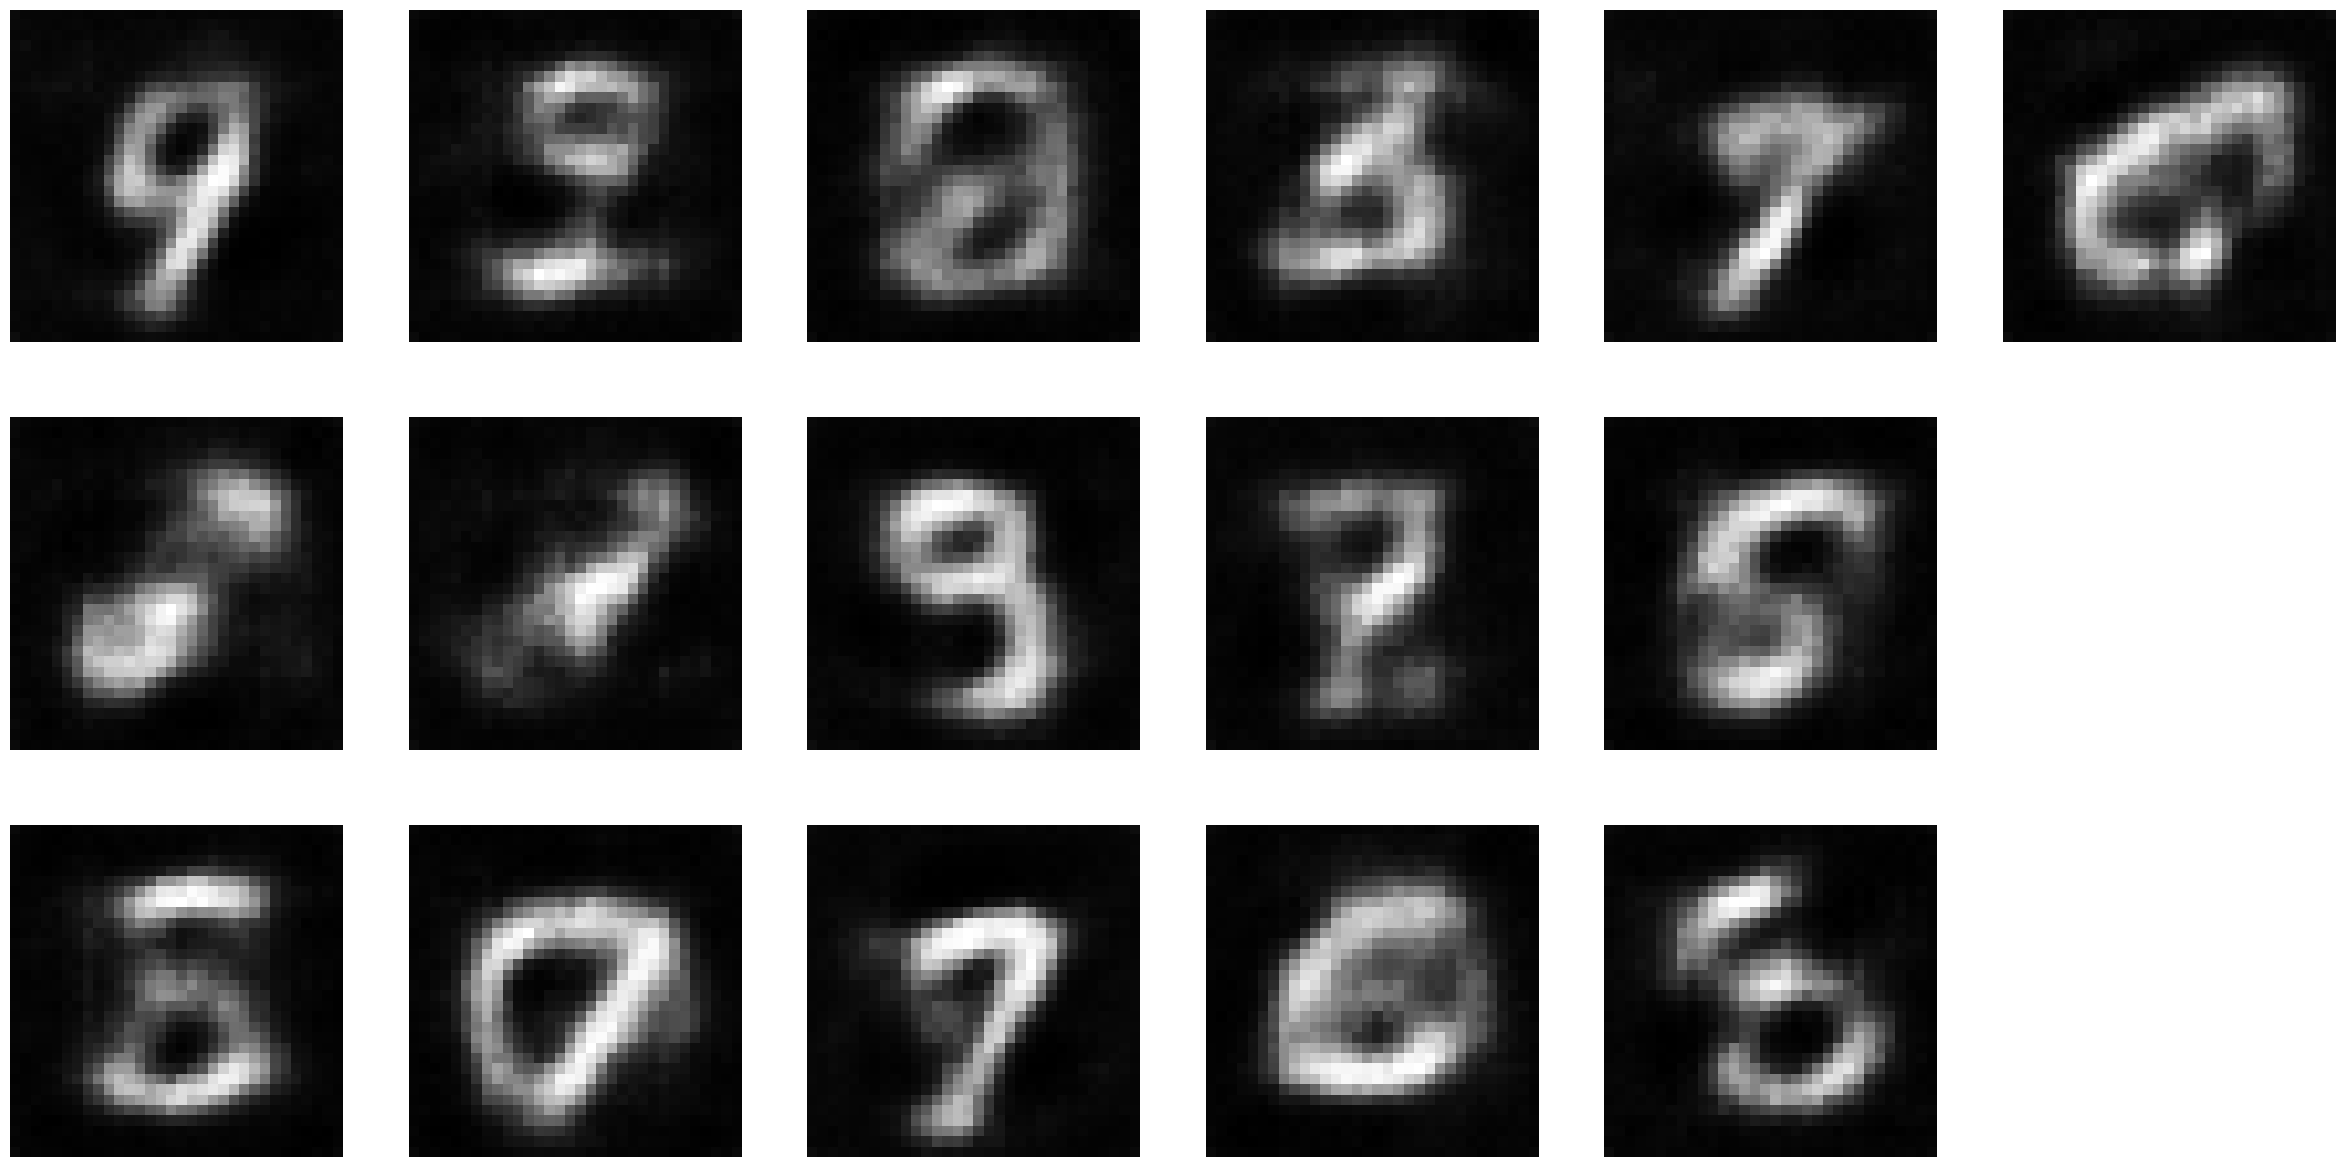

Iter 469/469 [Epoch 2/40] KL_z1 = 3.3635  KL_z2c = 18.4380  KL_c = -190.4970  L2 = 26.5589: : 469it [00:10, 45.50it/s]
Iter 469/469 [Epoch 3/40] KL_z1 = 1.4692  KL_z2c = 11.6787  KL_c = -188.1812  L2 = 22.8349: : 469it [00:10, 45.66it/s]
Iter 469/469 [Epoch 4/40] KL_z1 = 1.0287  KL_z2c = 11.2444  KL_c = -187.6260  L2 = 20.7155: : 469it [00:09, 47.04it/s]
Iter 469/469 [Epoch 5/40] KL_z1 = 0.7703  KL_z2c = 11.5543  KL_c = -187.1039  L2 = 19.1749: : 469it [00:10, 44.35it/s]


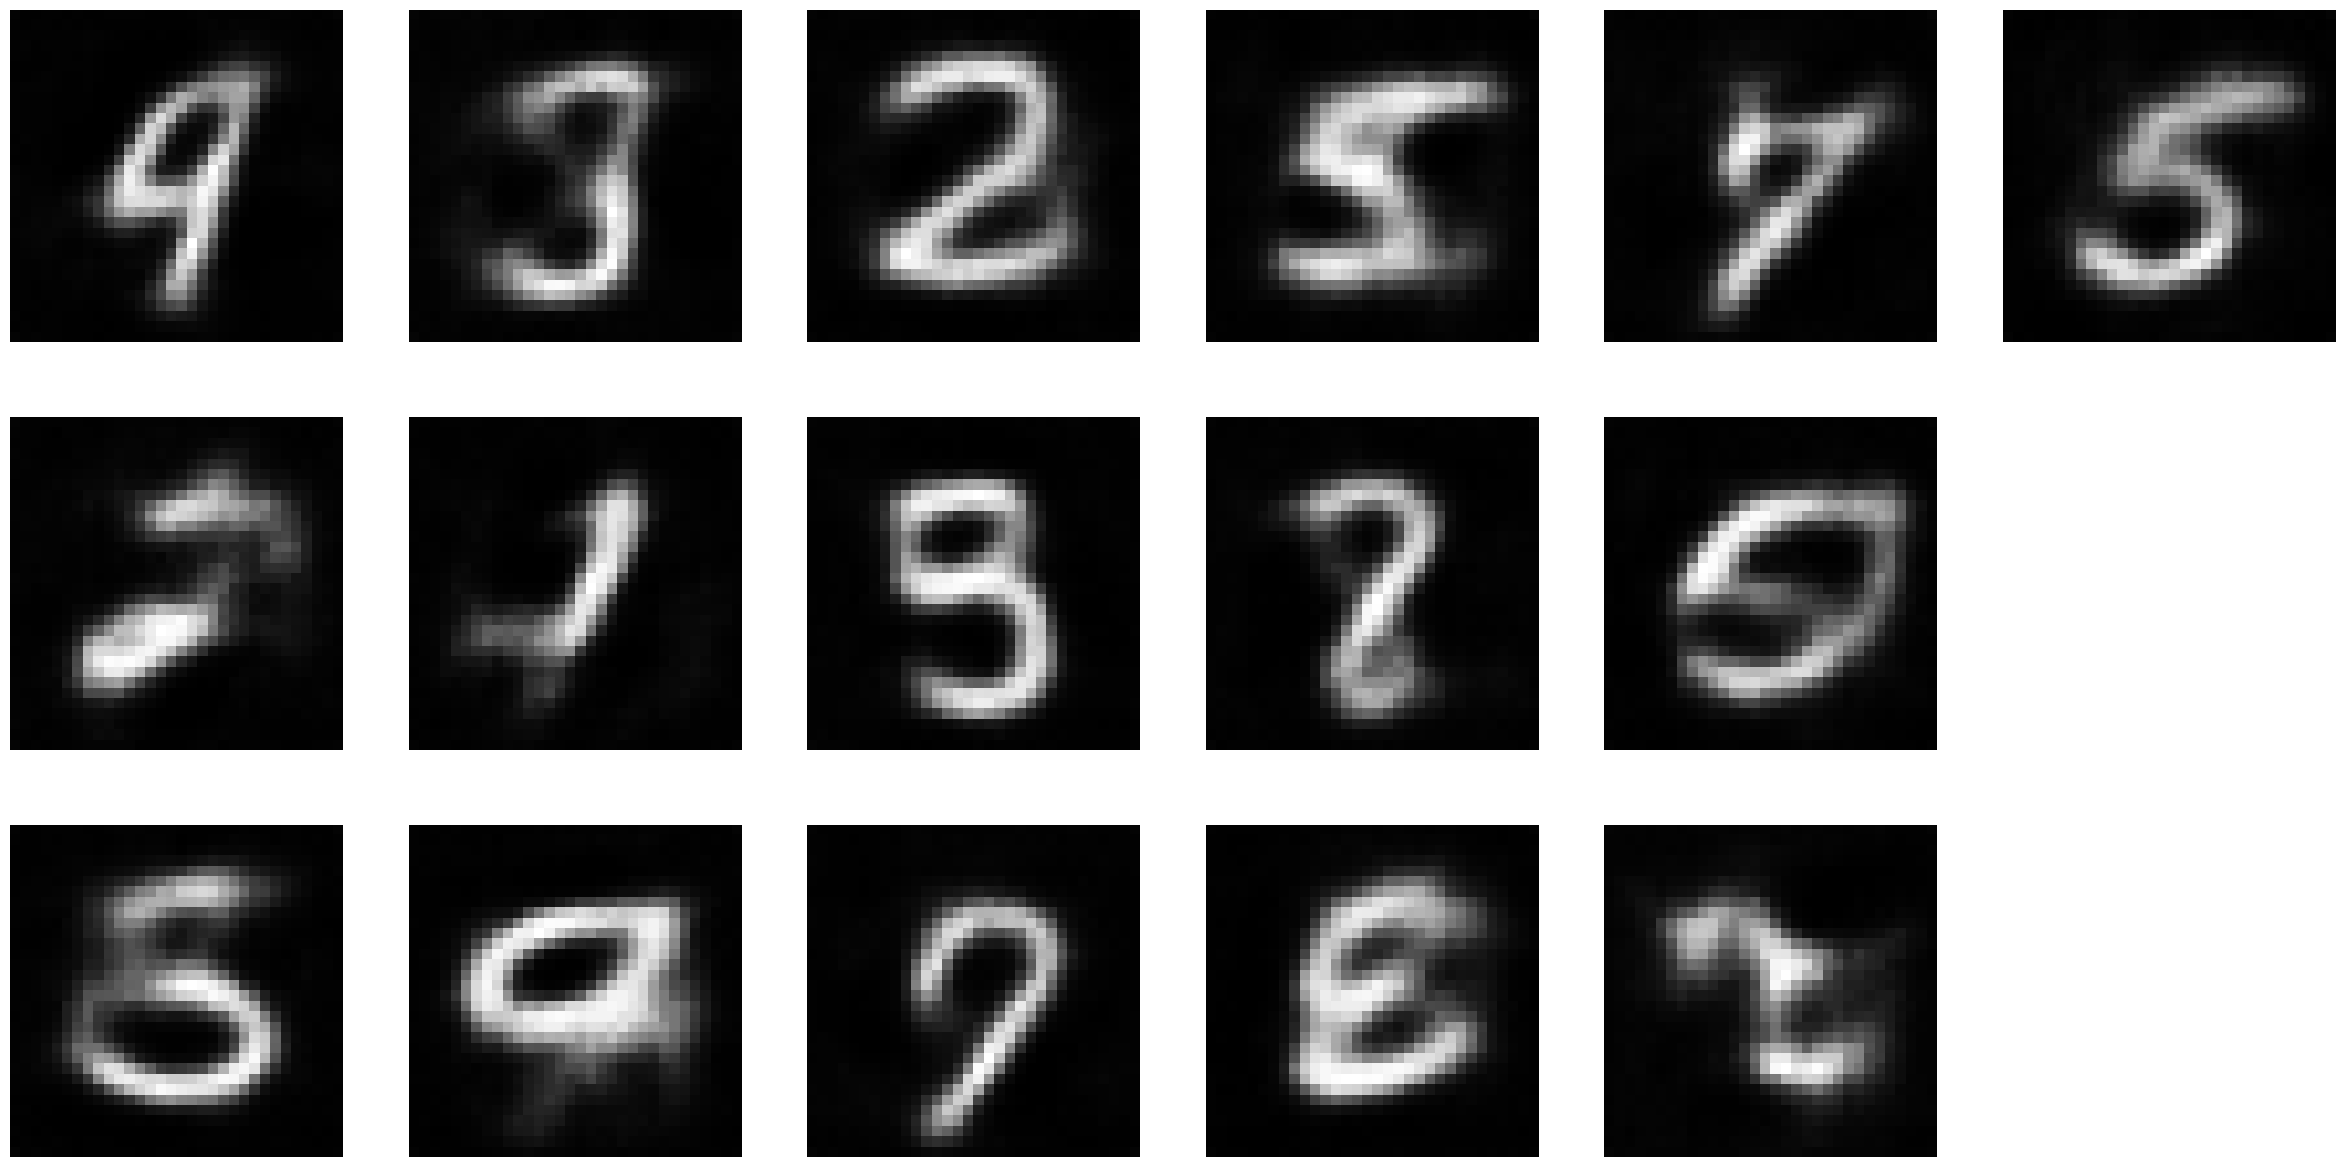

Iter 469/469 [Epoch 6/40] KL_z1 = 0.6213  KL_z2c = 11.7828  KL_c = -186.5804  L2 = 18.0777: : 469it [00:10, 46.85it/s]
Iter 469/469 [Epoch 7/40] KL_z1 = 0.5381  KL_z2c = 11.9407  KL_c = -185.9415  L2 = 17.3285: : 469it [00:10, 46.56it/s]
Iter 469/469 [Epoch 8/40] KL_z1 = 0.4899  KL_z2c = 12.1098  KL_c = -185.1650  L2 = 16.7367: : 469it [00:09, 48.04it/s]
Iter 469/469 [Epoch 9/40] KL_z1 = 0.4411  KL_z2c = 12.2123  KL_c = -184.4328  L2 = 16.2328: : 469it [00:11, 41.07it/s]


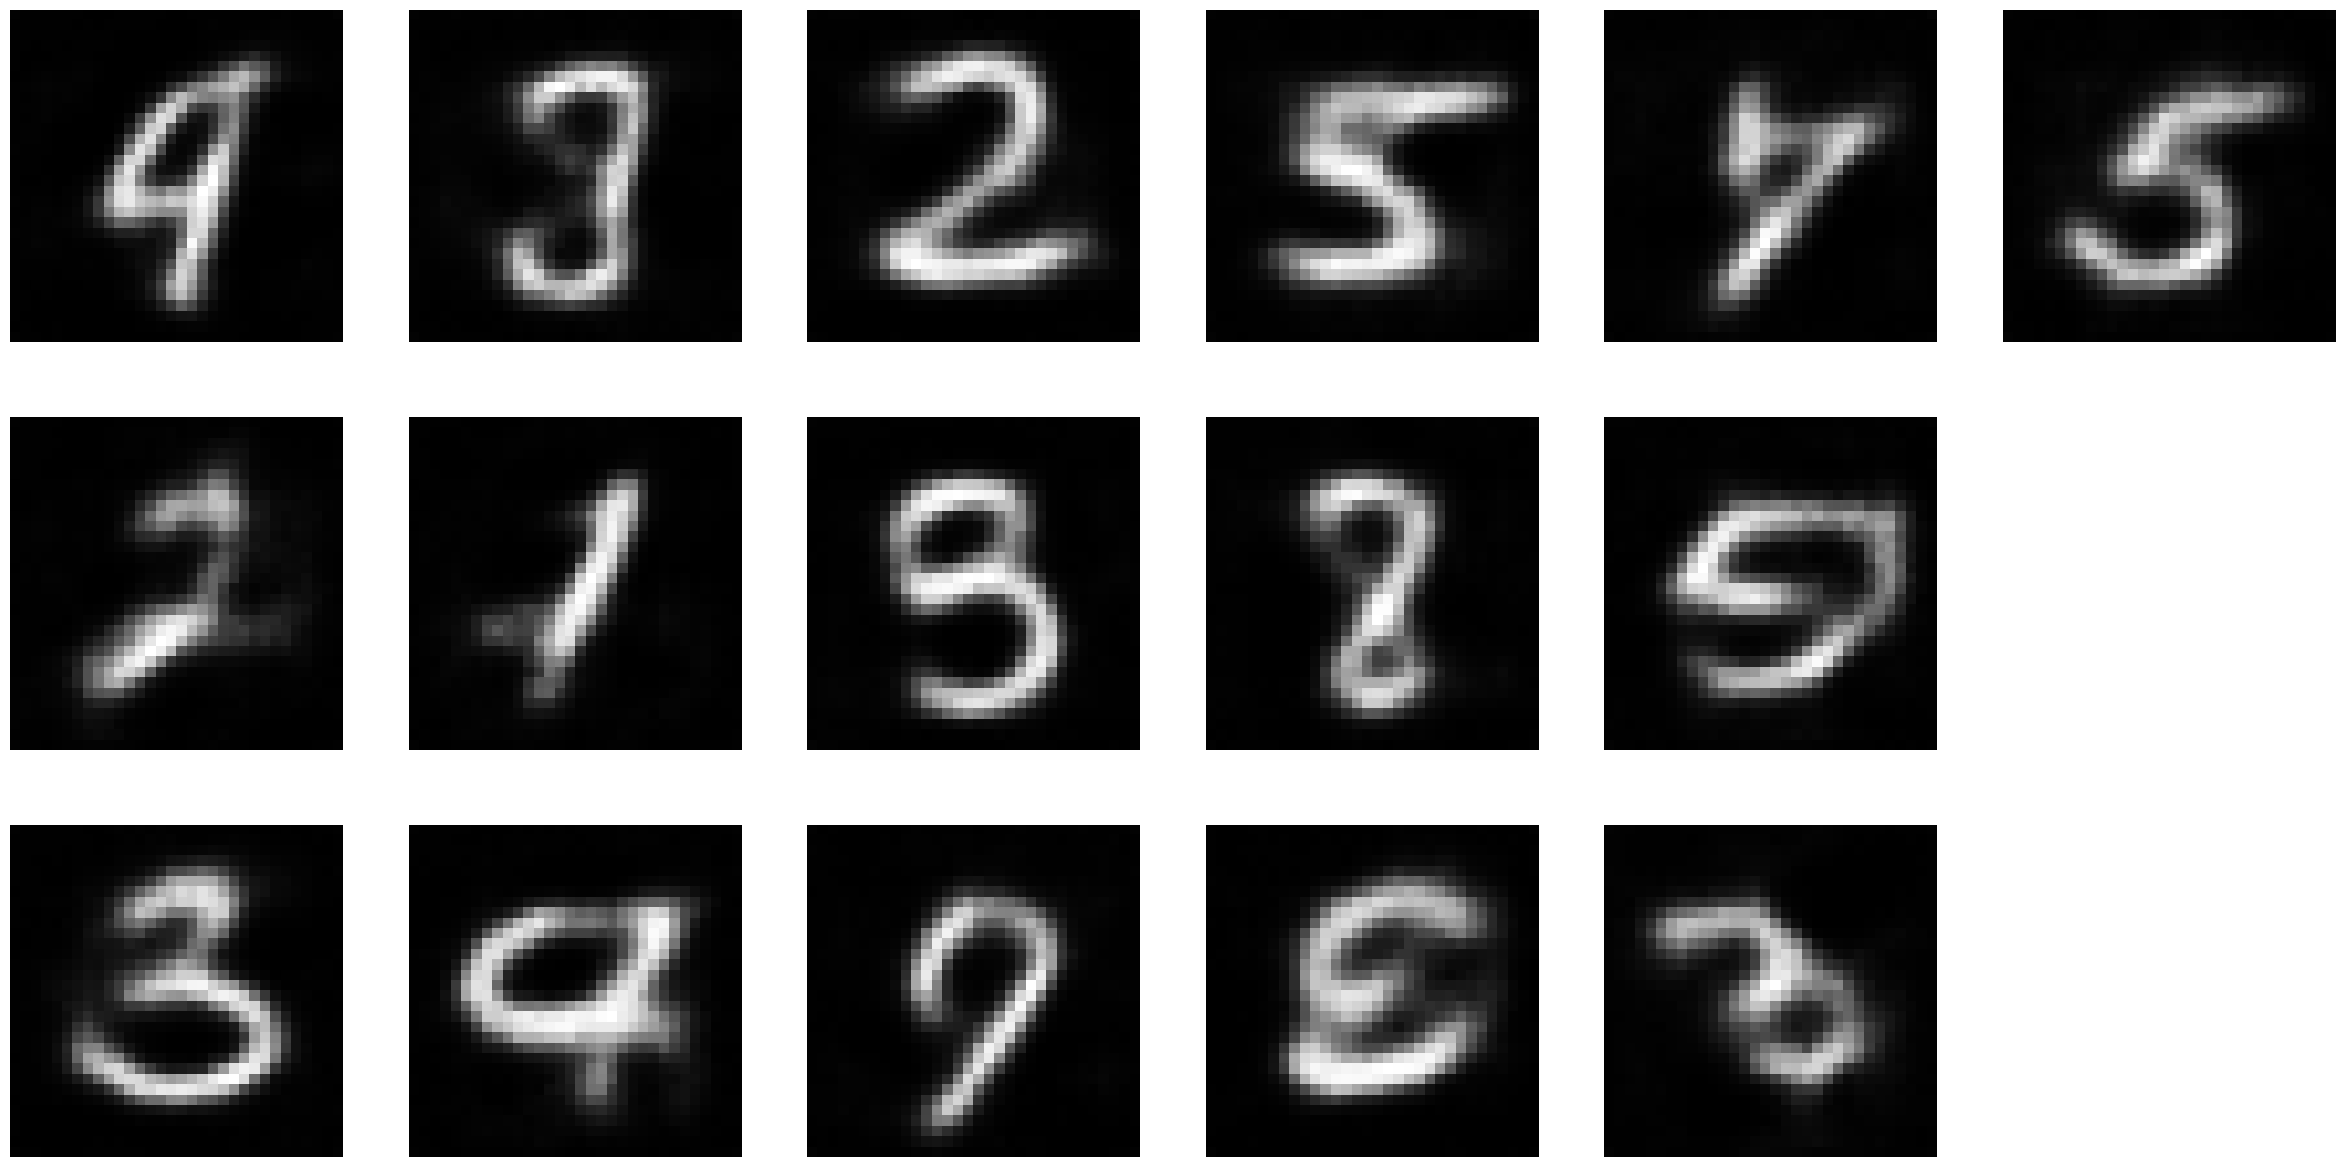

Iter 469/469 [Epoch 10/40] KL_z1 = 0.4048  KL_z2c = 12.2987  KL_c = -183.6872  L2 = 15.8142: : 469it [00:11, 40.28it/s]
Iter 469/469 [Epoch 11/40] KL_z1 = 0.4058  KL_z2c = 12.4182  KL_c = -182.9413  L2 = 15.5623: : 469it [00:11, 42.10it/s]
Iter 469/469 [Epoch 12/40] KL_z1 = 0.3531  KL_z2c = 12.4262  KL_c = -182.3330  L2 = 15.2583: : 469it [00:10, 43.86it/s]
Iter 469/469 [Epoch 13/40] KL_z1 = 0.3364  KL_z2c = 12.4585  KL_c = -181.6651  L2 = 15.0275: : 469it [00:10, 45.28it/s]


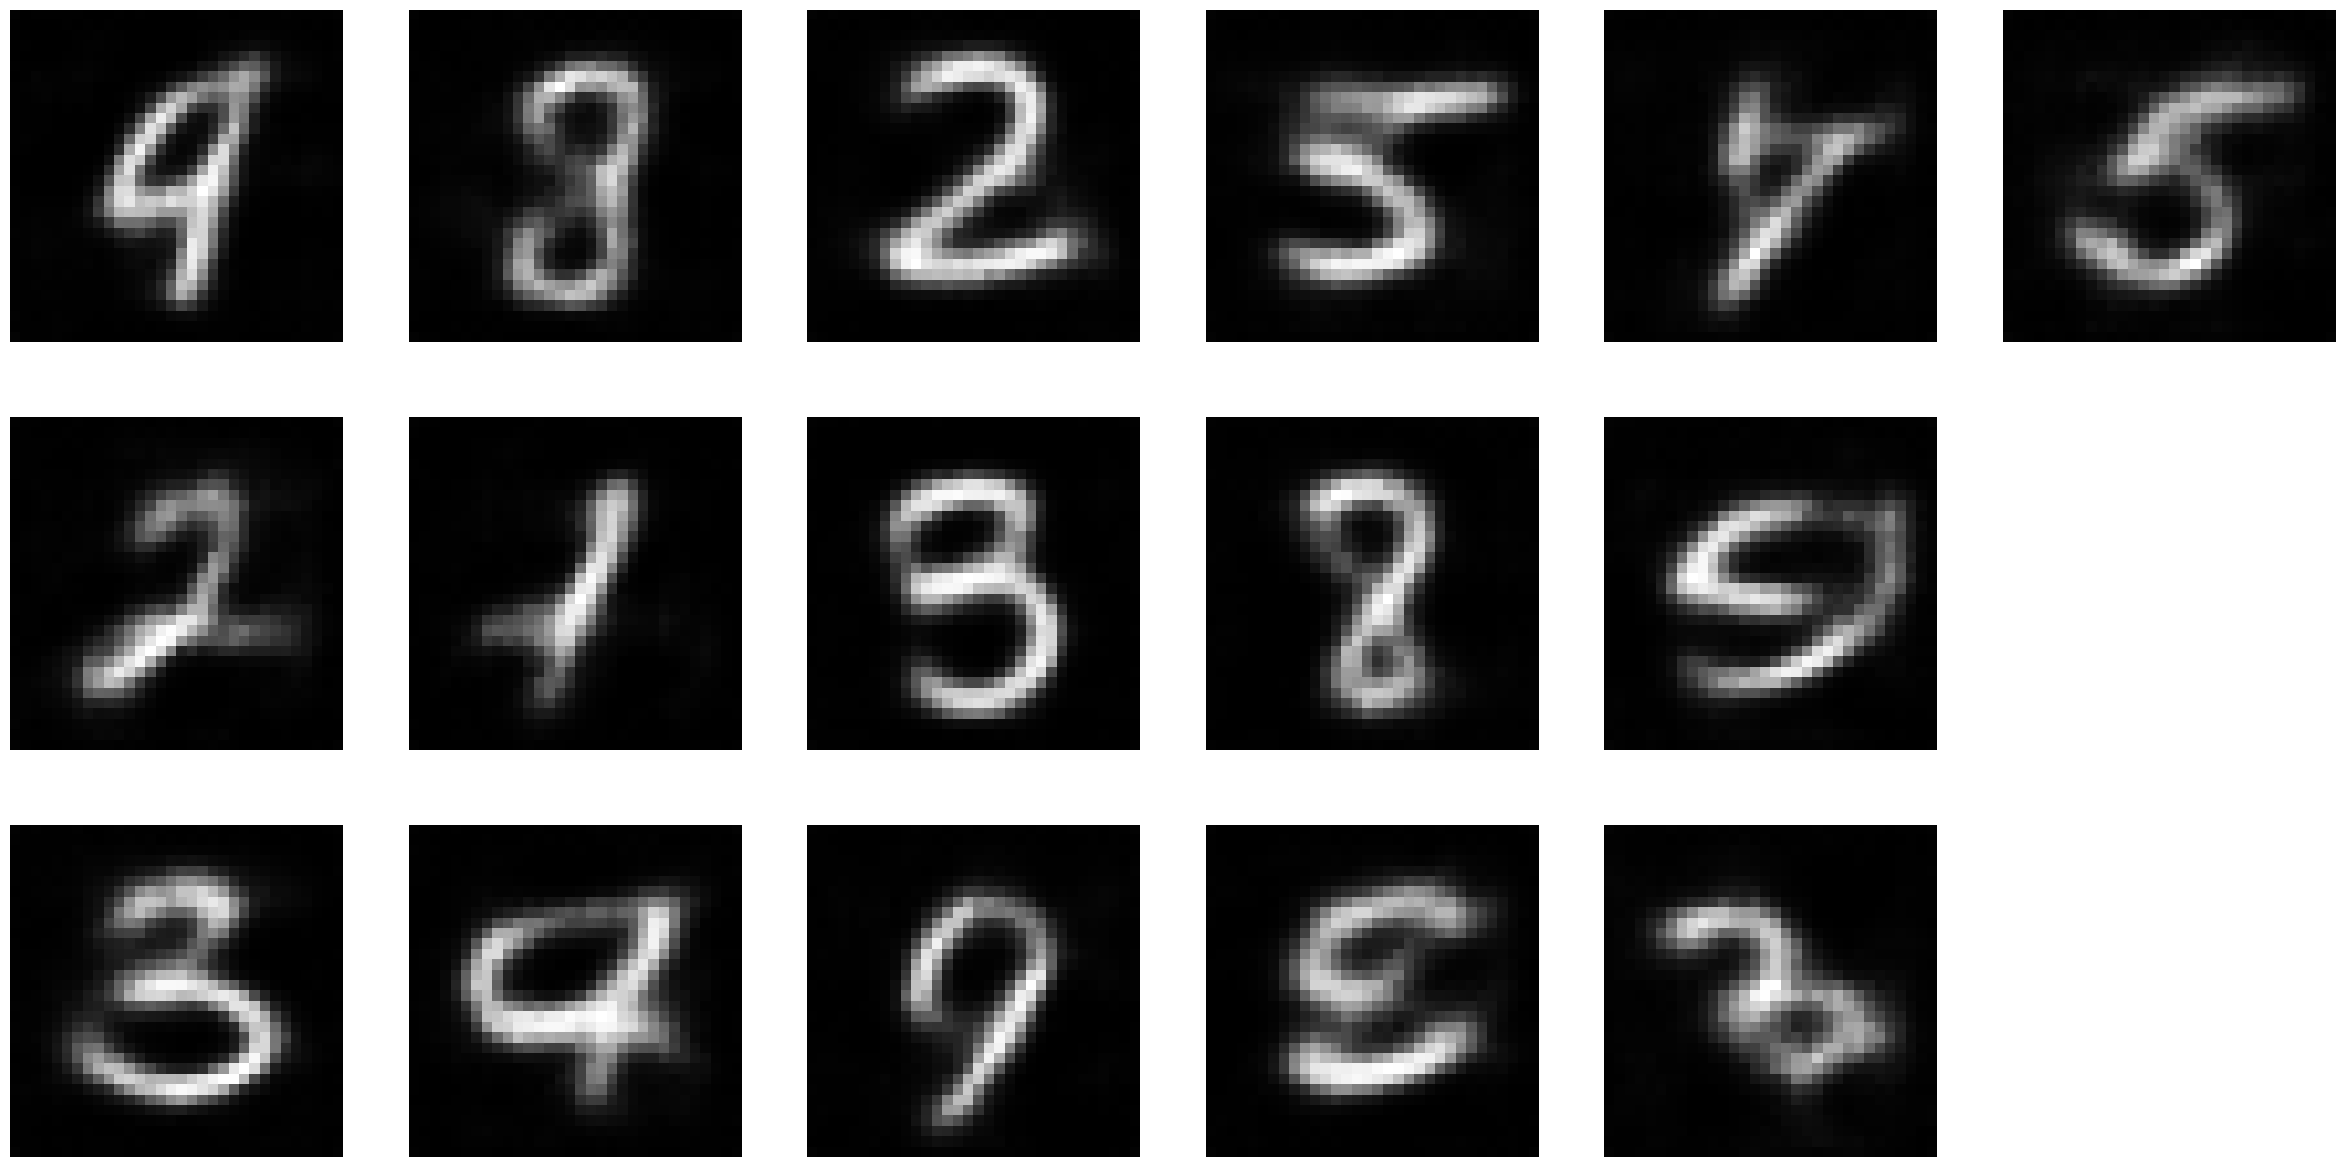

Iter 469/469 [Epoch 14/40] KL_z1 = 0.3234  KL_z2c = 12.5240  KL_c = -181.1246  L2 = 14.7971: : 469it [00:09, 47.53it/s]
Iter 469/469 [Epoch 15/40] KL_z1 = 0.3079  KL_z2c = 12.5725  KL_c = -180.6082  L2 = 14.6351: : 469it [00:10, 45.74it/s]
Iter 469/469 [Epoch 16/40] KL_z1 = 0.3409  KL_z2c = 12.6130  KL_c = -180.0978  L2 = 14.4441: : 469it [00:09, 48.44it/s]
Iter 469/469 [Epoch 17/40] KL_z1 = 0.2745  KL_z2c = 12.6067  KL_c = -179.5618  L2 = 14.2983: : 469it [00:12, 38.96it/s]


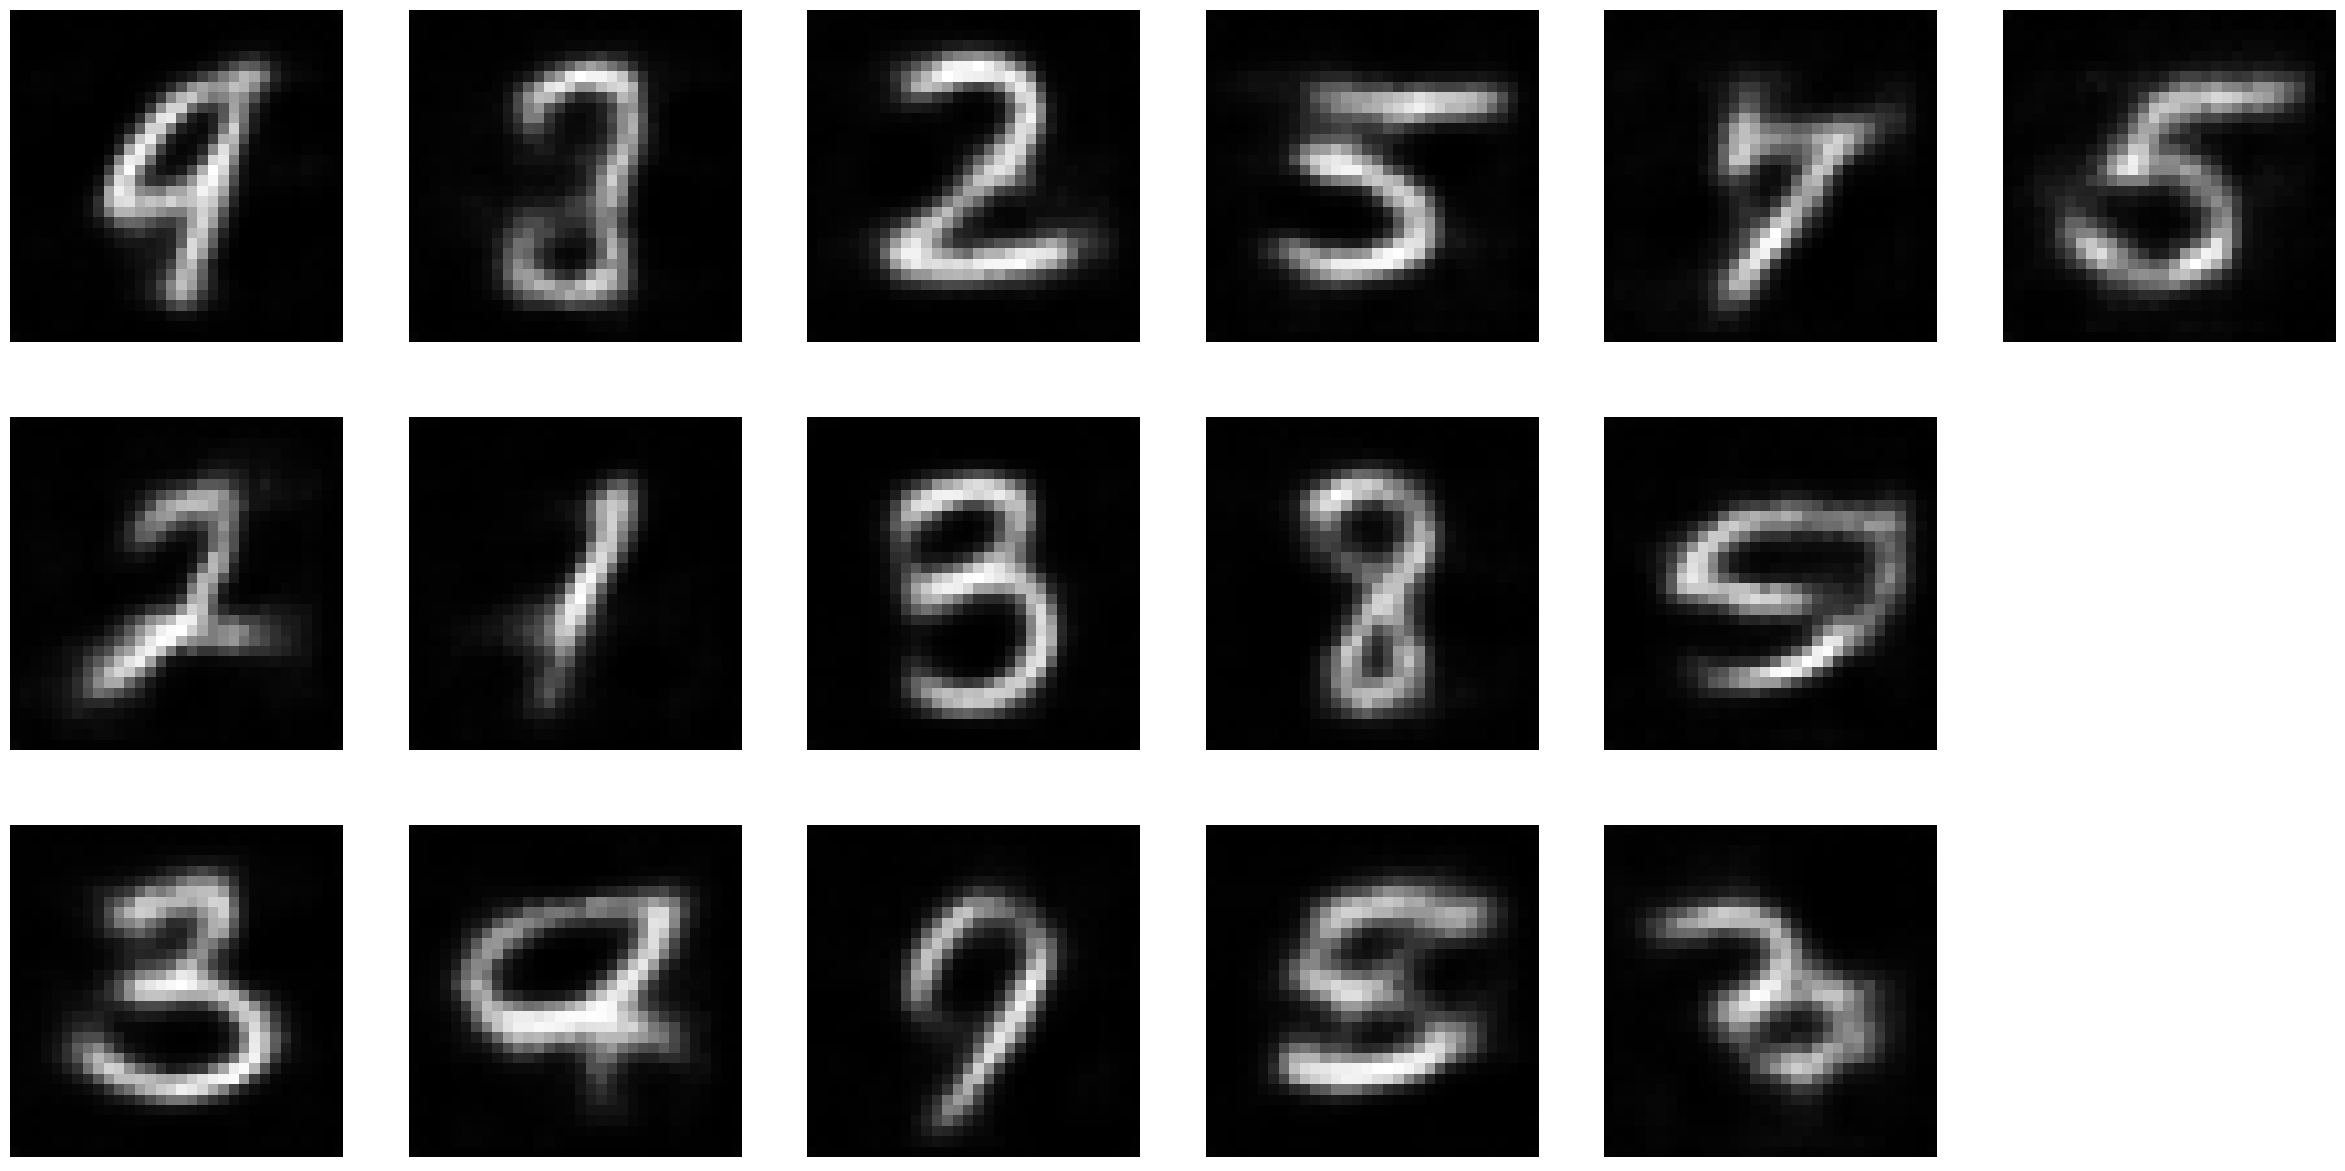

Iter 469/469 [Epoch 18/40] KL_z1 = 0.2703  KL_z2c = 12.6346  KL_c = -179.1218  L2 = 14.1739: : 469it [00:09, 49.72it/s]
Iter 469/469 [Epoch 19/40] KL_z1 = 0.2619  KL_z2c = 12.6790  KL_c = -178.6606  L2 = 14.0599: : 469it [00:09, 50.42it/s]
Iter 469/469 [Epoch 20/40] KL_z1 = 0.2587  KL_z2c = 12.7261  KL_c = -178.1637  L2 = 13.9042: : 469it [00:10, 46.18it/s]
Iter 469/469 [Epoch 21/40] KL_z1 = 0.2409  KL_z2c = 12.7054  KL_c = -177.6912  L2 = 13.8059: : 469it [00:09, 50.84it/s]


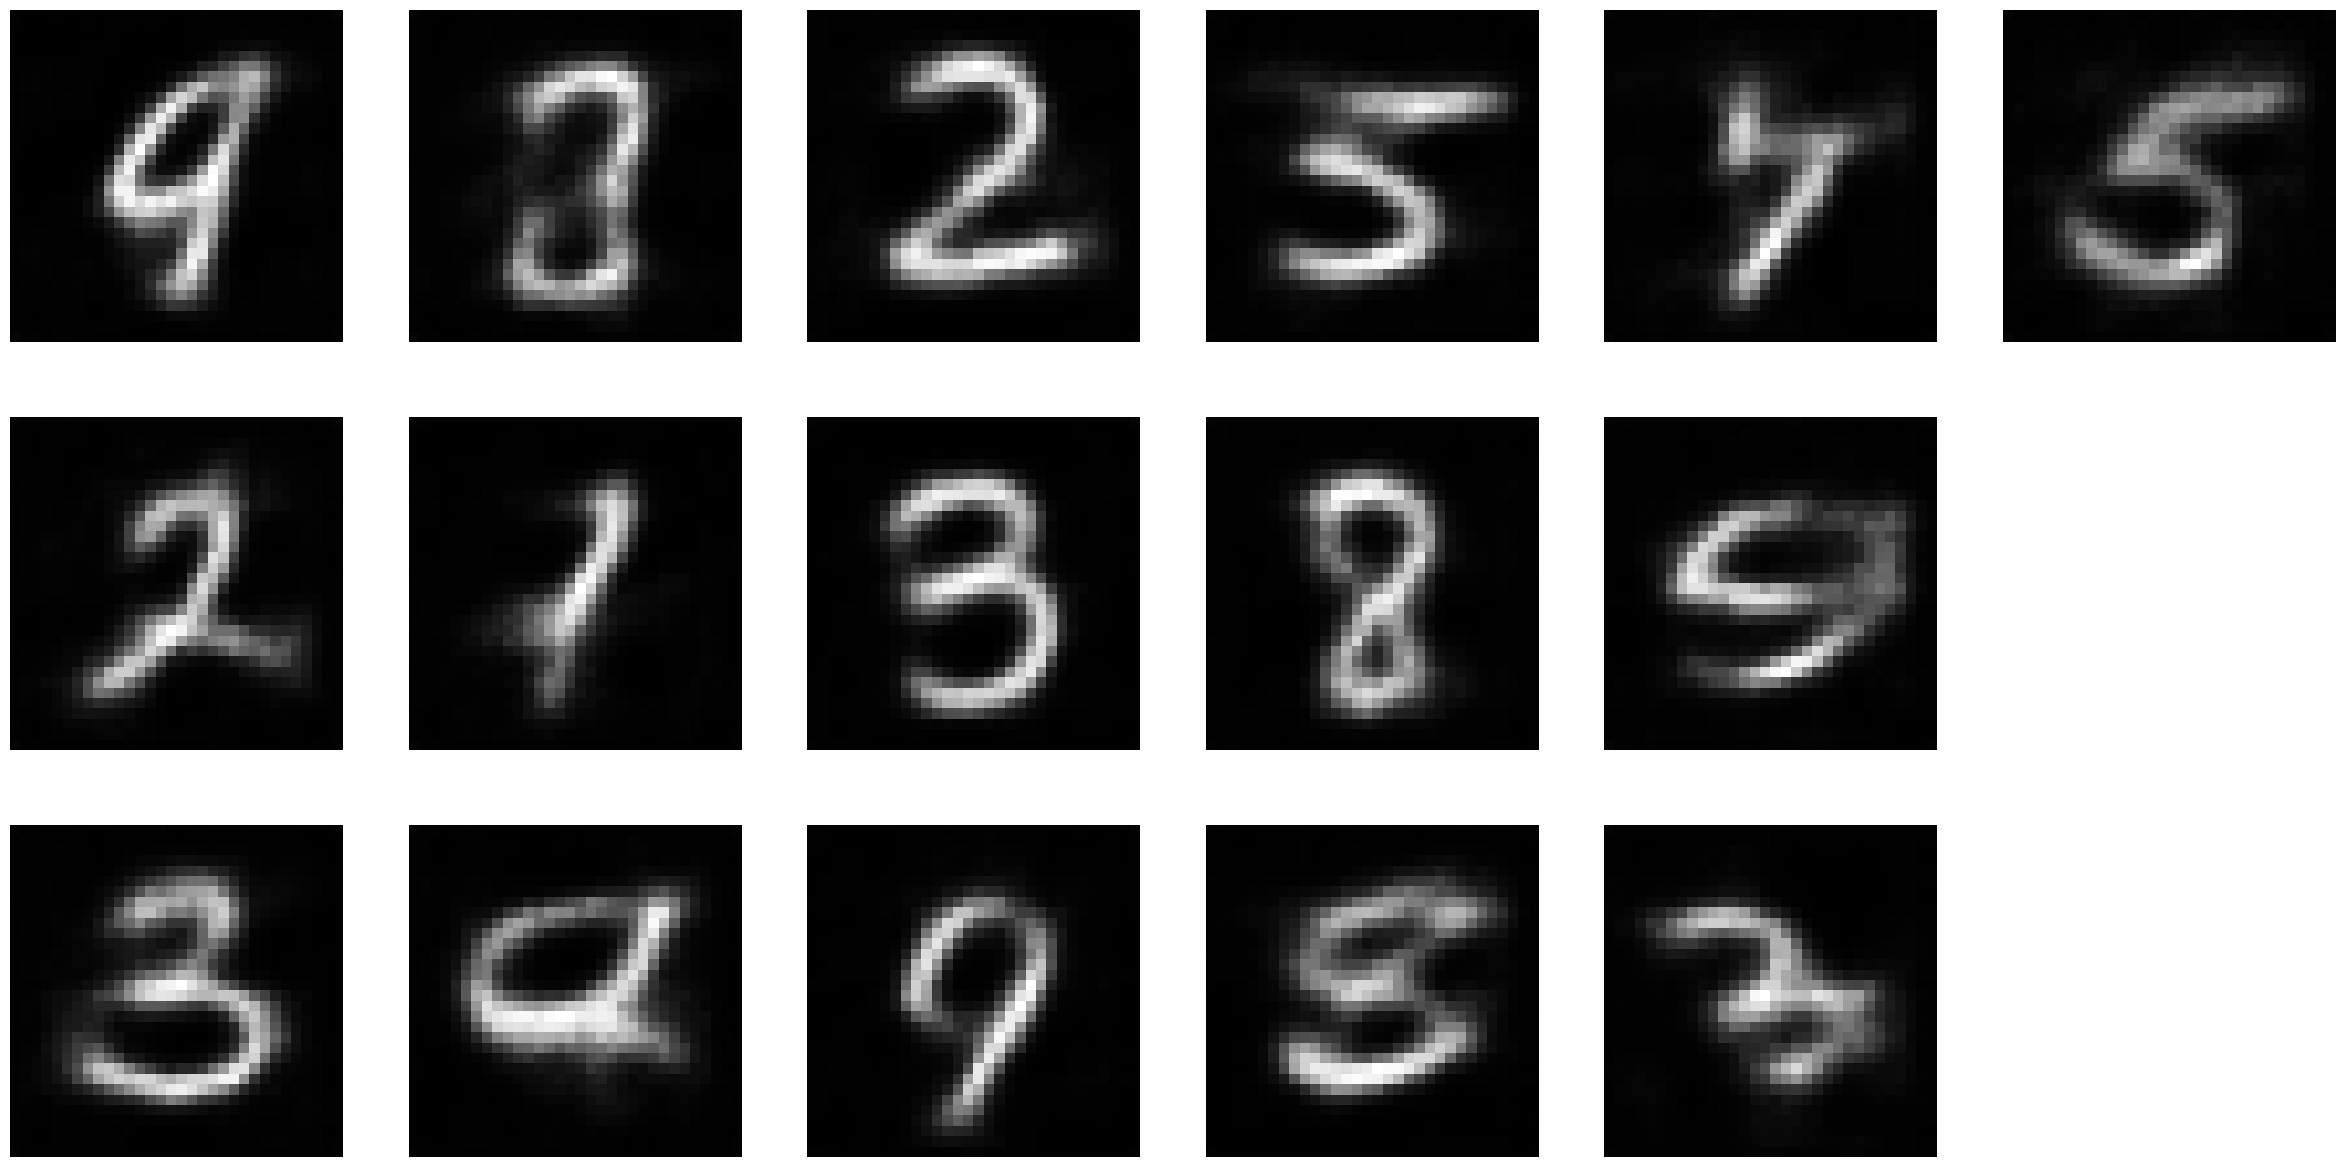

Iter 469/469 [Epoch 22/40] KL_z1 = 0.2326  KL_z2c = 12.7153  KL_c = -177.3016  L2 = 13.7013: : 469it [00:08, 55.21it/s]
Iter 469/469 [Epoch 23/40] KL_z1 = 0.2275  KL_z2c = 12.7635  KL_c = -176.7912  L2 = 13.6116: : 469it [00:08, 55.26it/s]
Iter 469/469 [Epoch 24/40] KL_z1 = 0.2209  KL_z2c = 12.7494  KL_c = -176.4293  L2 = 13.5088: : 469it [00:09, 51.91it/s]
Iter 469/469 [Epoch 25/40] KL_z1 = 0.2345  KL_z2c = 12.7935  KL_c = -175.9976  L2 = 13.4100: : 469it [00:08, 53.61it/s]


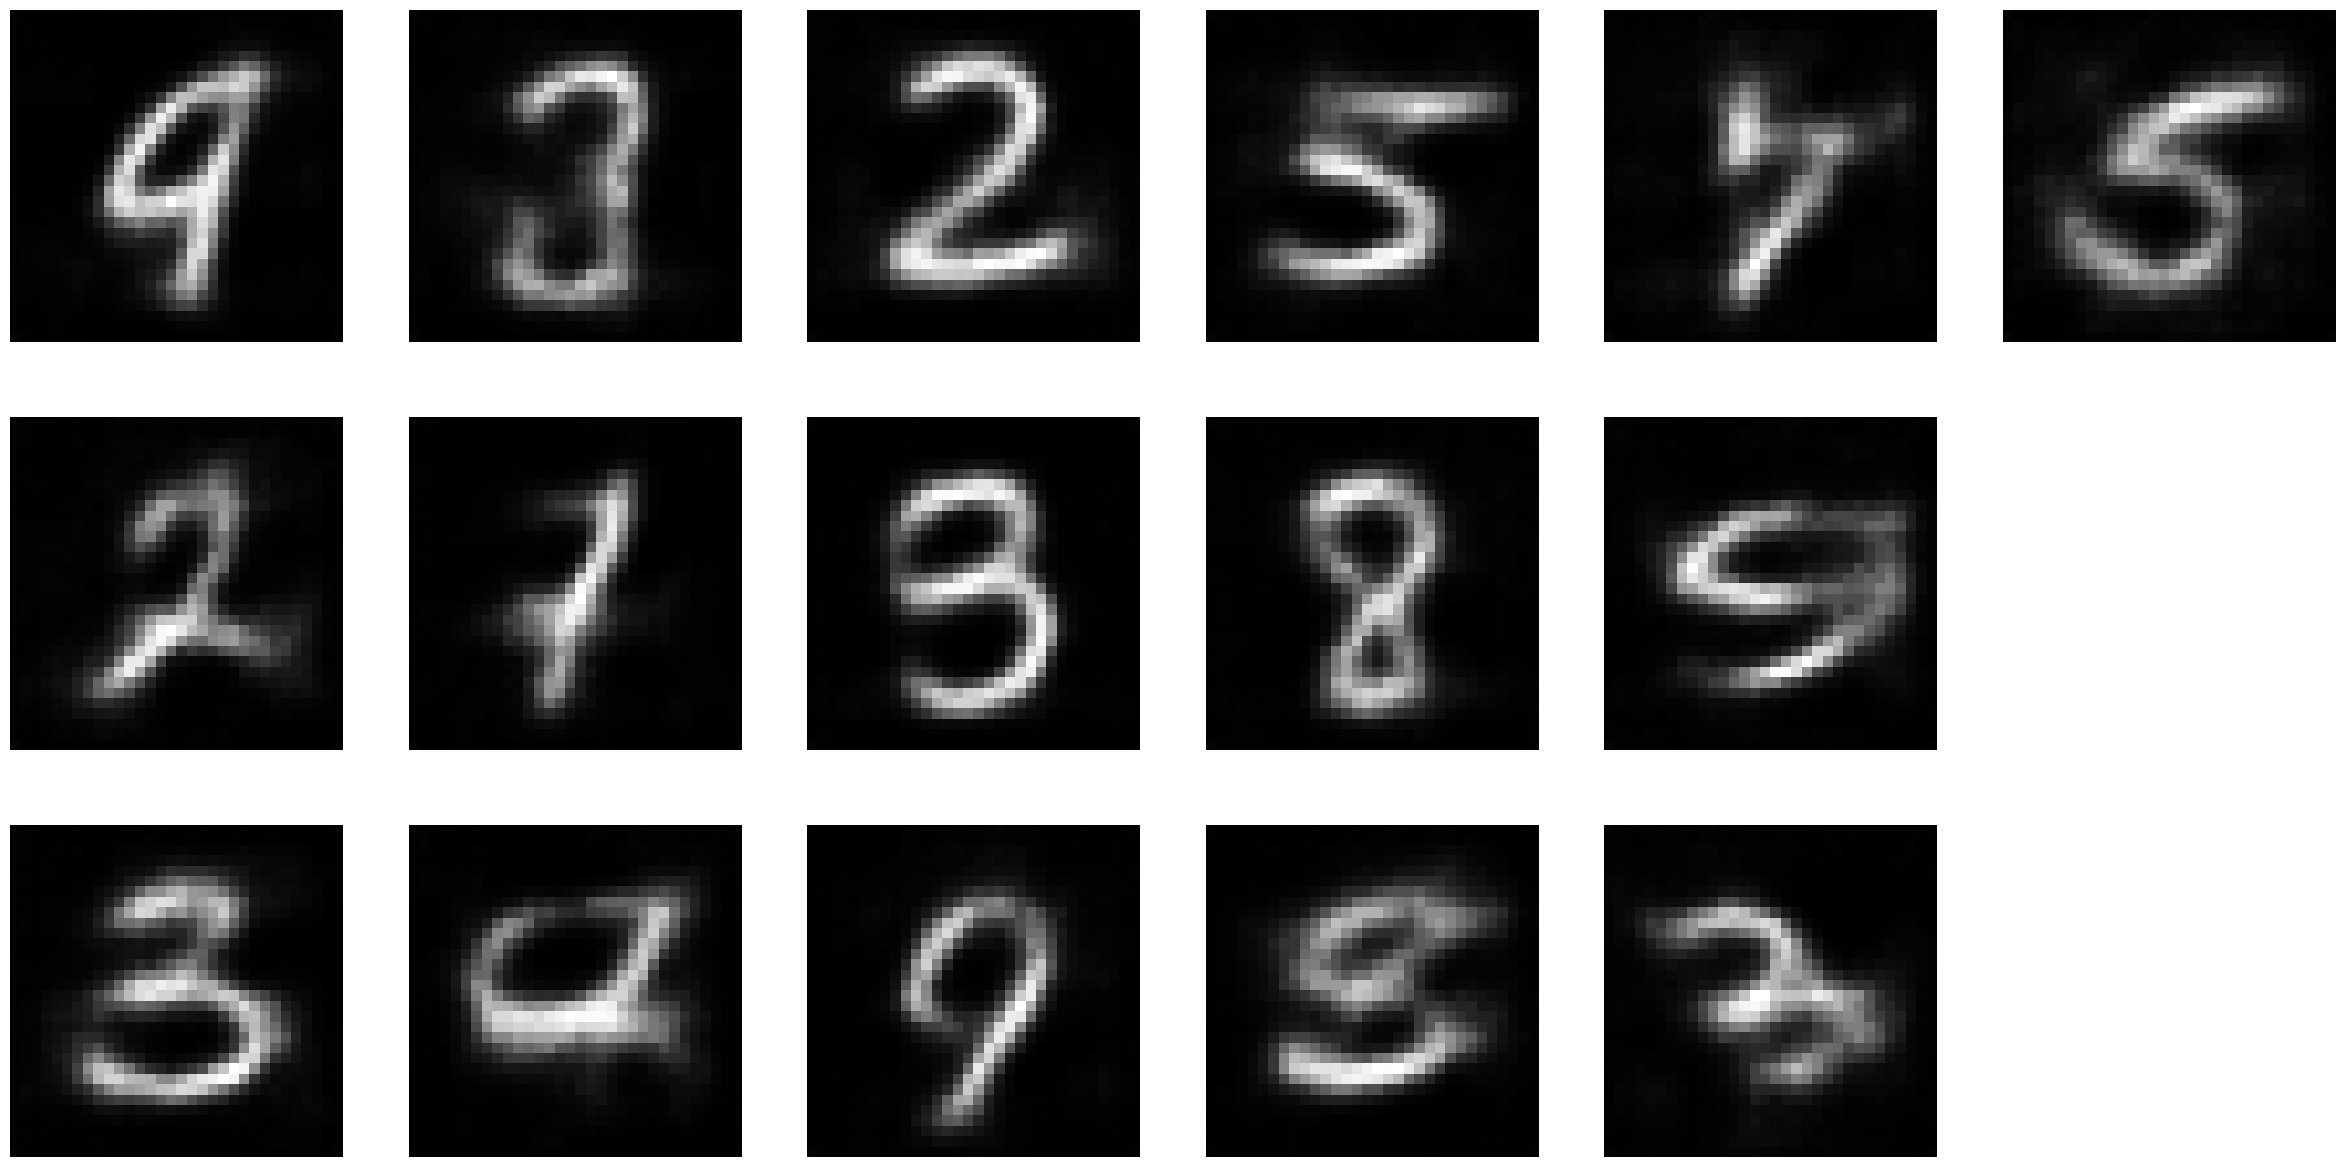

Iter 469/469 [Epoch 26/40] KL_z1 = 0.2011  KL_z2c = 12.7694  KL_c = -175.6618  L2 = 13.3281: : 469it [00:09, 50.35it/s]
Iter 469/469 [Epoch 27/40] KL_z1 = 0.2001  KL_z2c = 12.7939  KL_c = -175.1458  L2 = 13.2632: : 469it [00:09, 48.85it/s]
Iter 469/469 [Epoch 28/40] KL_z1 = 0.1987  KL_z2c = 12.8009  KL_c = -174.7265  L2 = 13.1956: : 469it [00:09, 51.33it/s]
Iter 469/469 [Epoch 29/40] KL_z1 = 0.1946  KL_z2c = 12.8390  KL_c = -174.2905  L2 = 13.1428: : 469it [00:10, 46.70it/s]


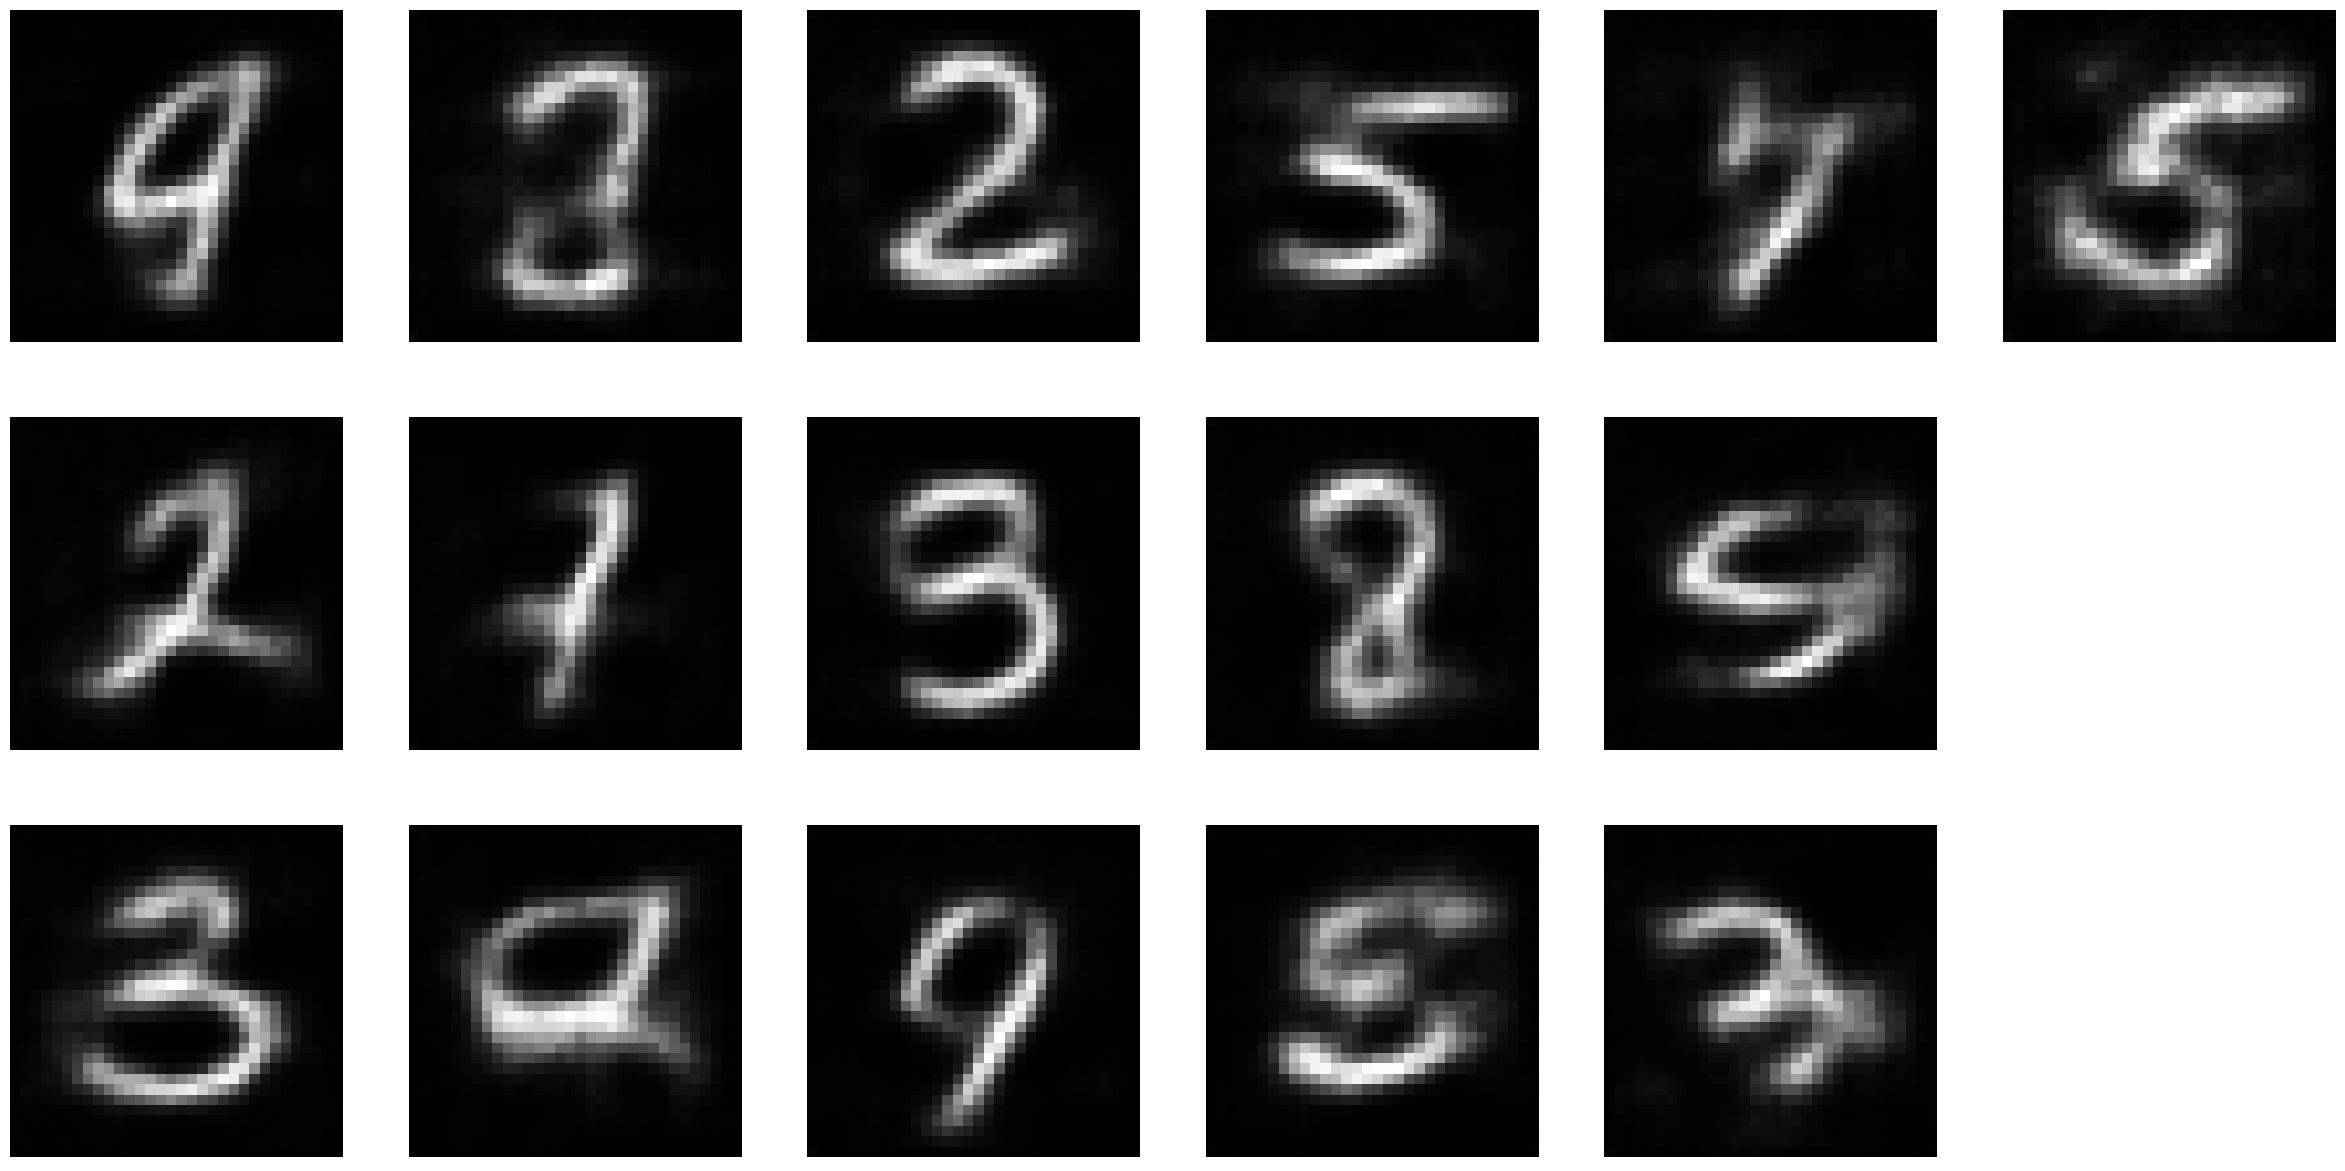

Iter 469/469 [Epoch 30/40] KL_z1 = 0.1895  KL_z2c = 12.8164  KL_c = -173.9074  L2 = 13.0735: : 469it [00:09, 50.23it/s]
Iter 469/469 [Epoch 31/40] KL_z1 = 0.1838  KL_z2c = 12.8094  KL_c = -173.5214  L2 = 12.9919: : 469it [00:08, 53.45it/s]
Iter 469/469 [Epoch 32/40] KL_z1 = 0.1798  KL_z2c = 12.8459  KL_c = -173.0383  L2 = 12.9281: : 469it [00:08, 54.26it/s]
Iter 469/469 [Epoch 33/40] KL_z1 = 0.1763  KL_z2c = 12.8473  KL_c = -172.6799  L2 = 12.8956: : 469it [00:10, 45.44it/s]


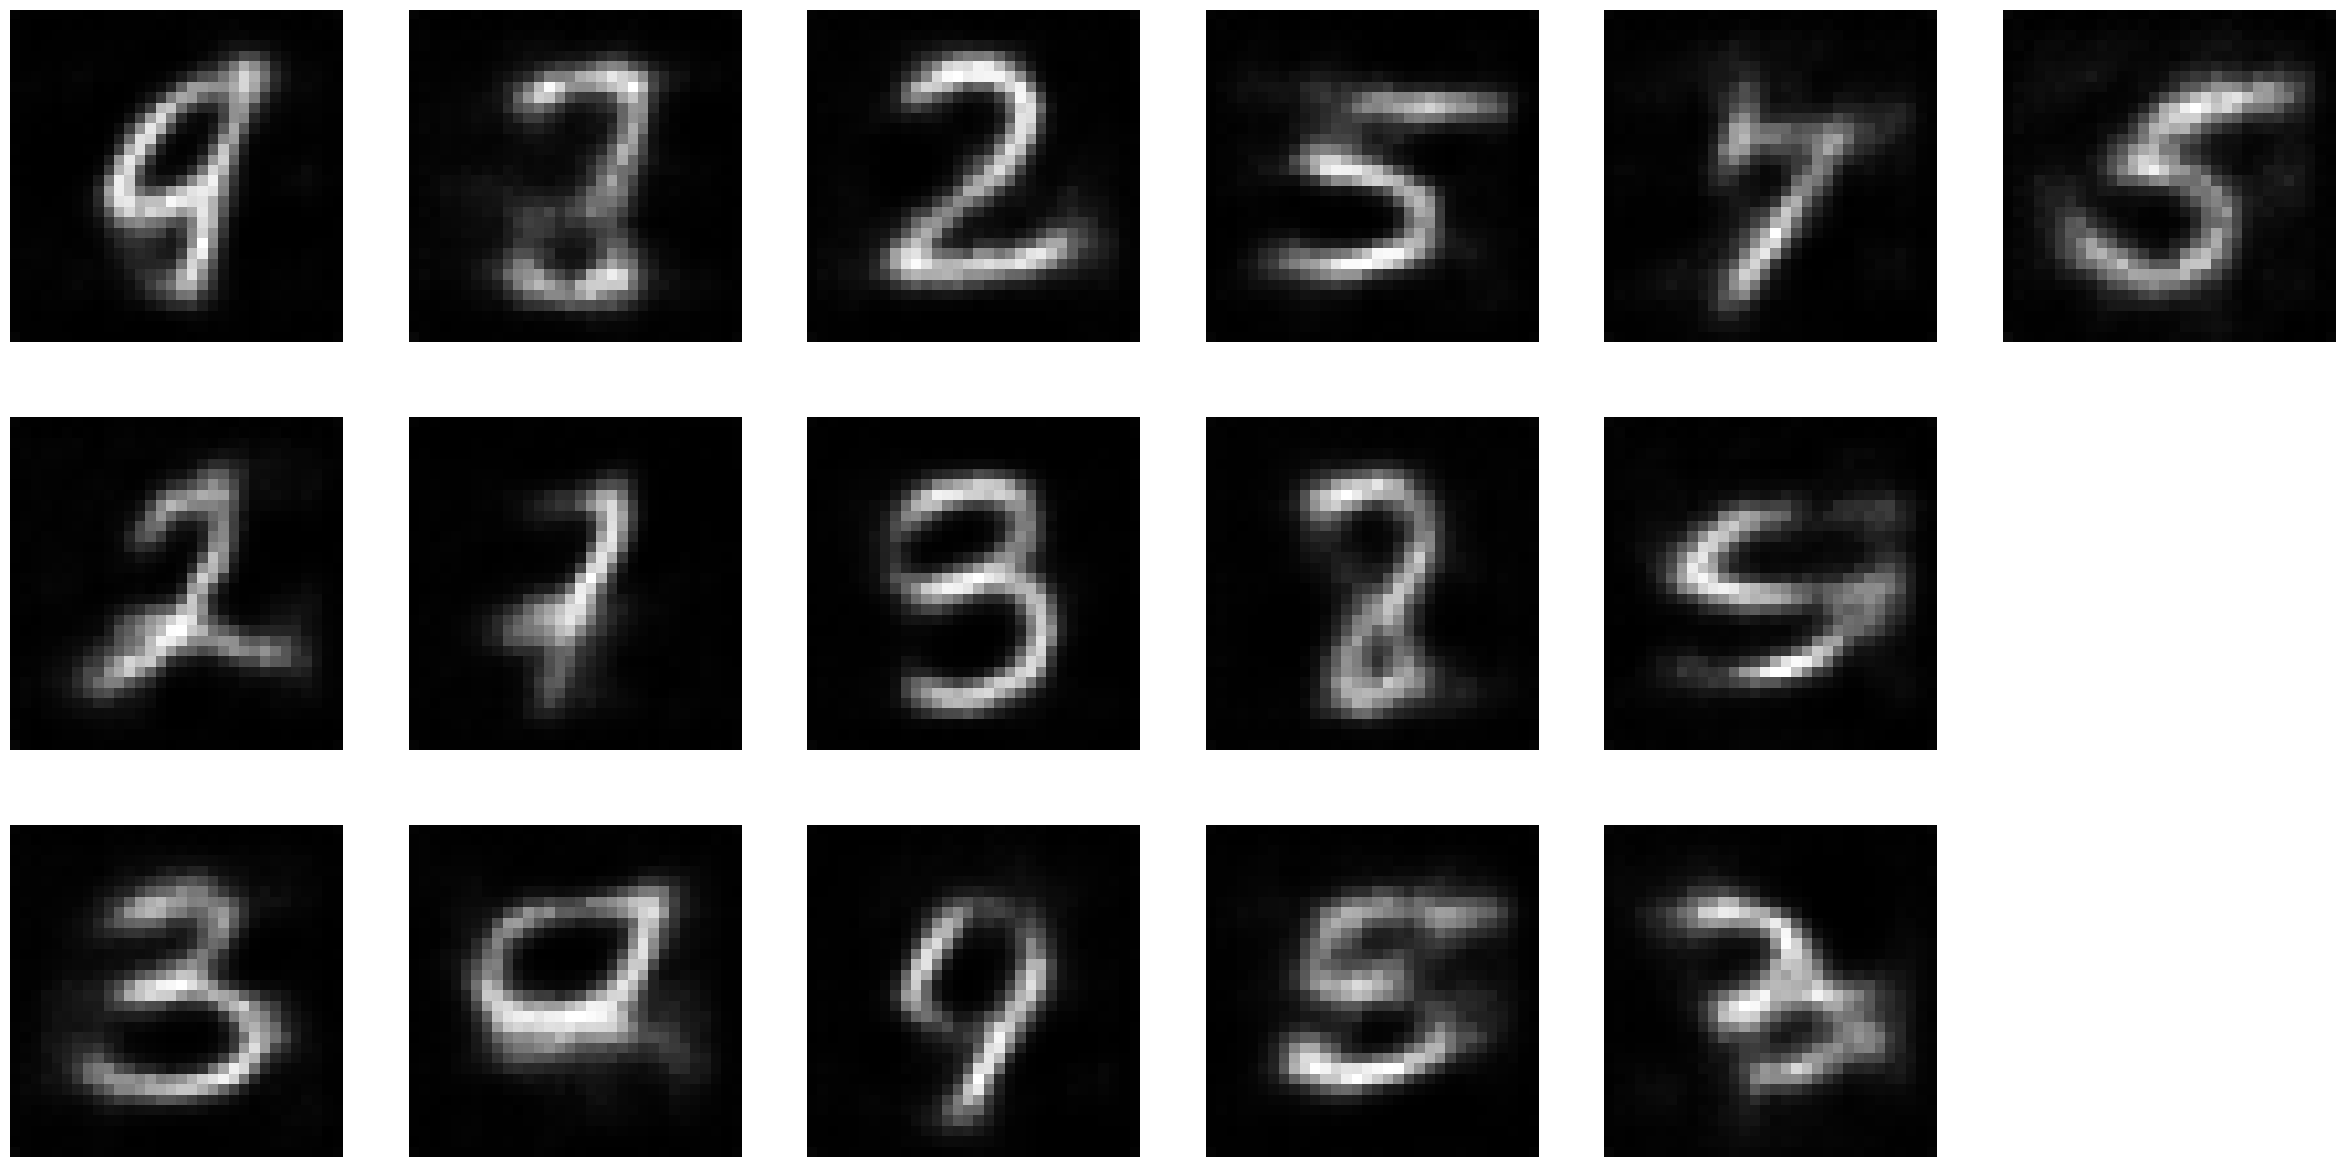

Iter 469/469 [Epoch 34/40] KL_z1 = 0.1721  KL_z2c = 12.8725  KL_c = -172.3061  L2 = 12.8470: : 469it [00:08, 52.90it/s]
Iter 469/469 [Epoch 35/40] KL_z1 = 0.1695  KL_z2c = 12.8596  KL_c = -171.8774  L2 = 12.7911: : 469it [00:08, 53.44it/s]
Iter 469/469 [Epoch 36/40] KL_z1 = 0.1675  KL_z2c = 12.8742  KL_c = -171.4143  L2 = 12.7399: : 469it [00:08, 56.17it/s]
Iter 469/469 [Epoch 37/40] KL_z1 = 0.1645  KL_z2c = 12.8797  KL_c = -171.0189  L2 = 12.6785: : 469it [00:08, 54.27it/s]


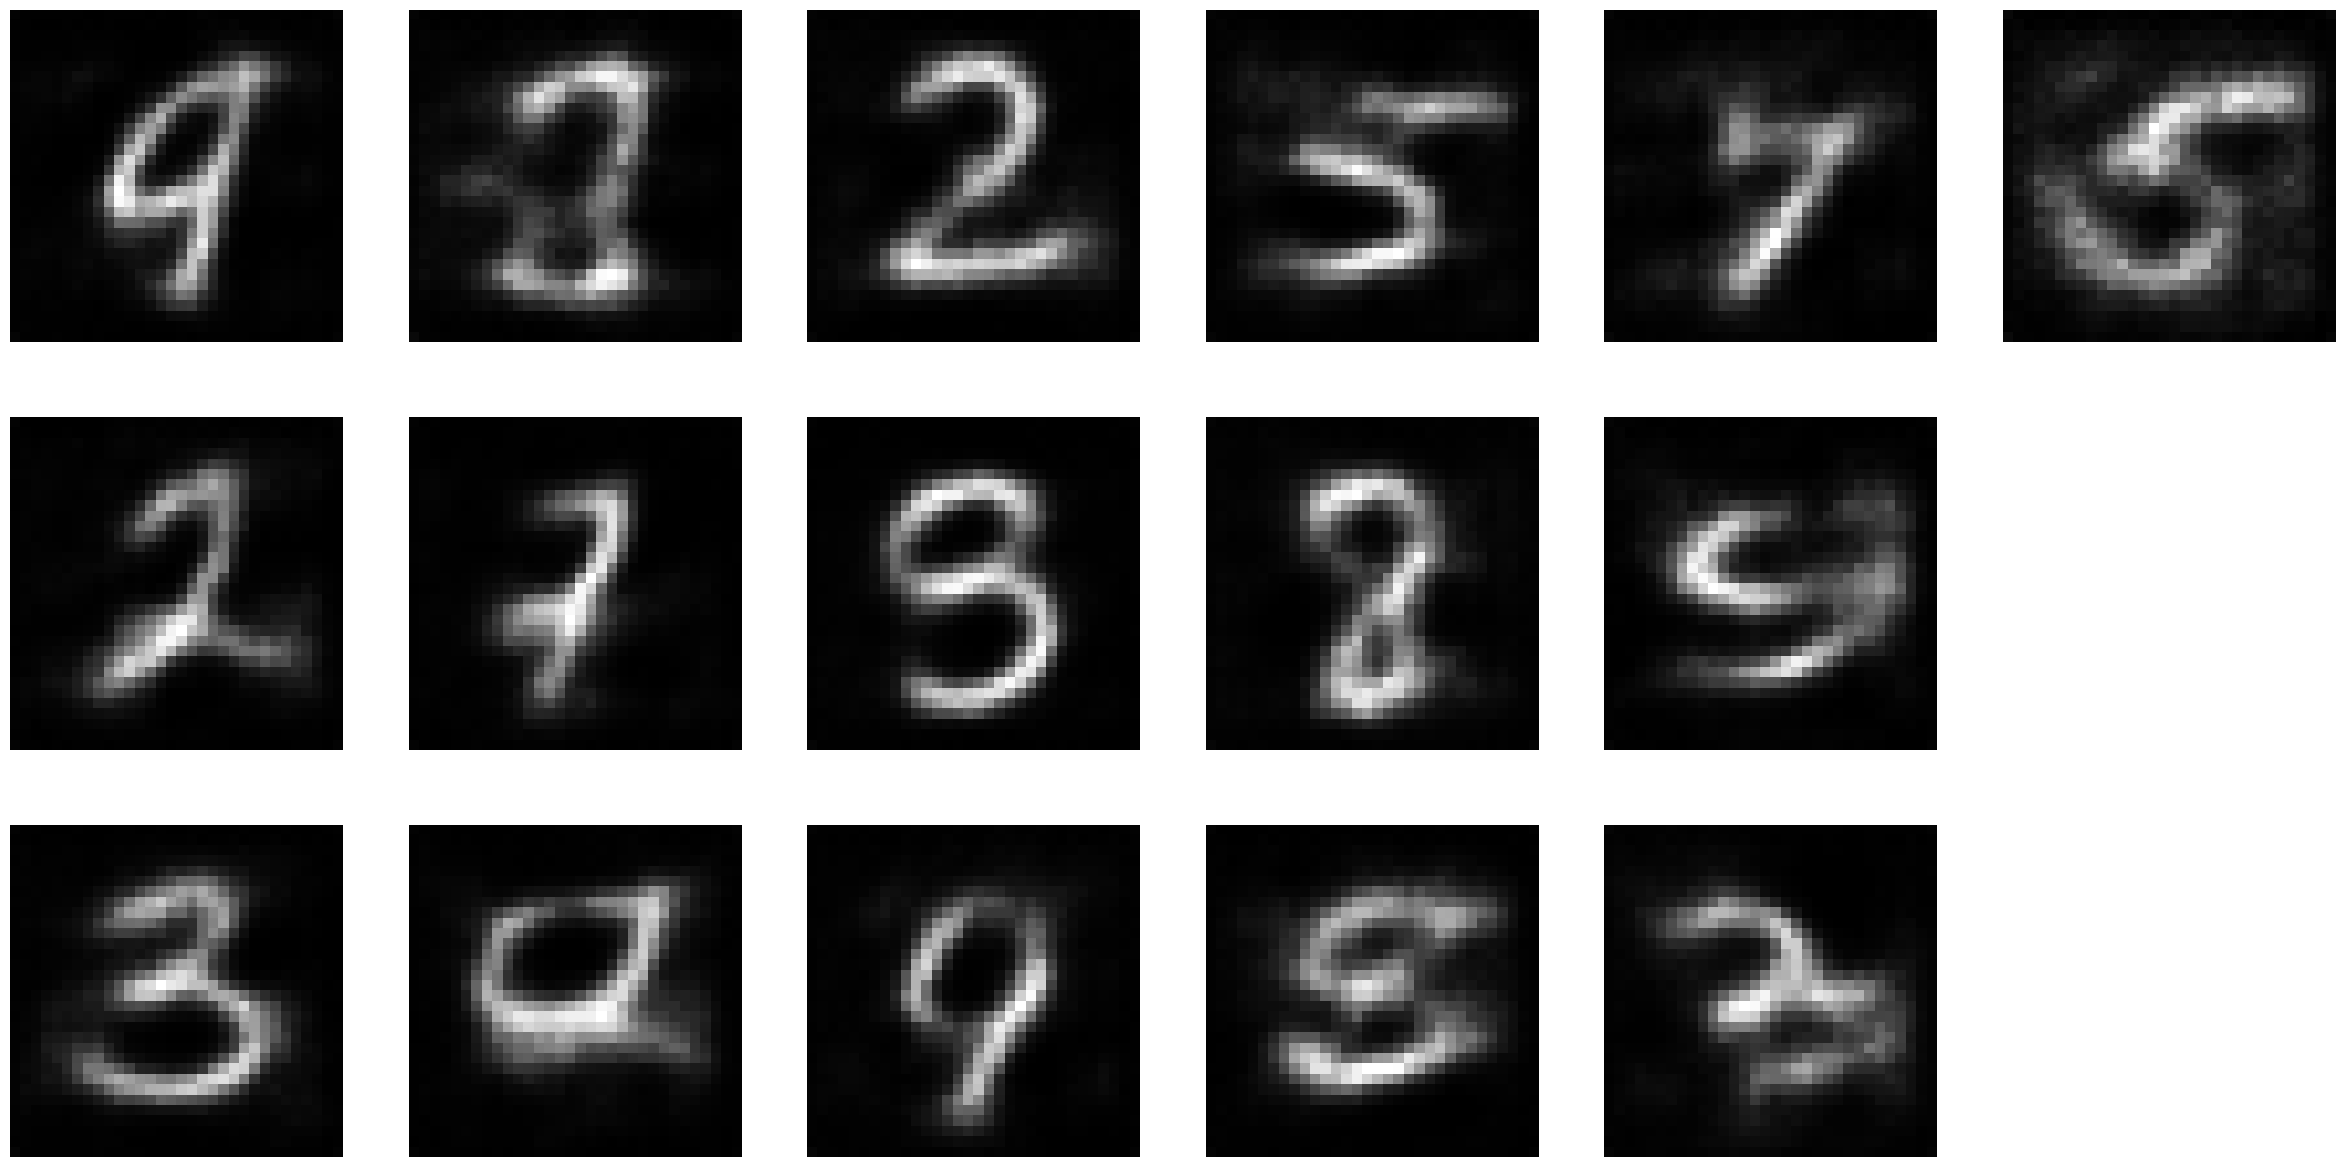

Iter 469/469 [Epoch 38/40] KL_z1 = 0.1598  KL_z2c = 12.8950  KL_c = -170.6353  L2 = 12.6649: : 469it [00:08, 53.87it/s]
Iter 469/469 [Epoch 39/40] KL_z1 = 0.1569  KL_z2c = 12.8736  KL_c = -170.3005  L2 = 12.6051: : 469it [00:08, 54.93it/s]
Iter 469/469 [Epoch 40/40] KL_z1 = 0.1558  KL_z2c = 12.8959  KL_c = -169.8403  L2 = 12.5698: : 469it [00:09, 50.46it/s]


In [8]:
visualize_noise = torch.randn(16, latent_size, 1, 1).float().to(device)

for epoch in range(num_epochs):
    pbar = tqdm(enumerate(data_loader))
    enc.train()
    dec.train()
    count = 0
    kl_z1_sum = 0
    kl_z2c_sum = 0
    kl_c_sum = 0
    l2_sum = 0
    for i, (data, _) in pbar:
        optimizer.zero_grad()
        x = data.to(device)
        b = x.shape[0]
        z1, c_onehot, z2 = enc(x, normal_generator)
        reconstructed = dec(z2.view(b, latent_size, 1, 1))

        kl_z1 = enc.kl_z1
        kl_z2c = enc.kl_z2c
        kl_c = enc.kl_c
        l2_loss = ((reconstructed - x) ** 2).sum()
        vae_loss = l2_loss
        # god whispered these magic thresholds to me
        if kl_z1.item() >= 5:
            vae_loss = vae_loss + kl_z1
        if kl_z2c.item() >= 5:
            vae_loss = vae_loss + kl_z2c
        if kl_c.item() >= -100:
            vae_loss = vae_loss + kl_c

        vae_loss.backward()
        optimizer.step()

        count += b
        kl_z1_sum += kl_z1.item()
        kl_z2c_sum += kl_z2c.item()
        kl_c_sum += kl_c.item()
        l2_sum += l2_loss.item()

        kl_z1_show = '{:.4f}'.format(kl_z1_sum / count)
        kl_z2c_show = '{:.4f}'.format(kl_z2c_sum / count)
        kl_c_show = '{:.4f}'.format(kl_c_sum / count)
        l2_loss_show = '{:.4f}'.format(l2_sum / count)

        pbar.set_description(
            f'Iter {i+1}/{len(data_loader)} [Epoch {epoch+1}/{num_epochs}] '
            f'KL_z1 = {kl_z1_show}  KL_z2c = {kl_z2c_show}  KL_c = {kl_c_show}  L2 = {l2_loss_show}'
        )

    if epoch % 4 == 0:
        with torch.no_grad():
            dec.eval()
            pred = dec(visualize_noise)
            plotter(pred.cpu())

In [ ]:
torch.save({
    "encoder": enc.state_dict(),
    "decoder": dec.state_dict()
}, "weights/gmvae_weights.pt")
# my brother in christ this took forever to debug i'm not letting you go my precious weights mwah mwah 大好きです

## Inference

We do a little trick to get $c$ to condition $z_2$. Remember the components that samples $z_2$ from $z_1$ right? This component is trained alongside the main network in real time through `KL_z2c`. Anyways, this allows $z_2$ to alternatively be generated from $z_1$ and $c$ (like we wanted). Here, let me show you

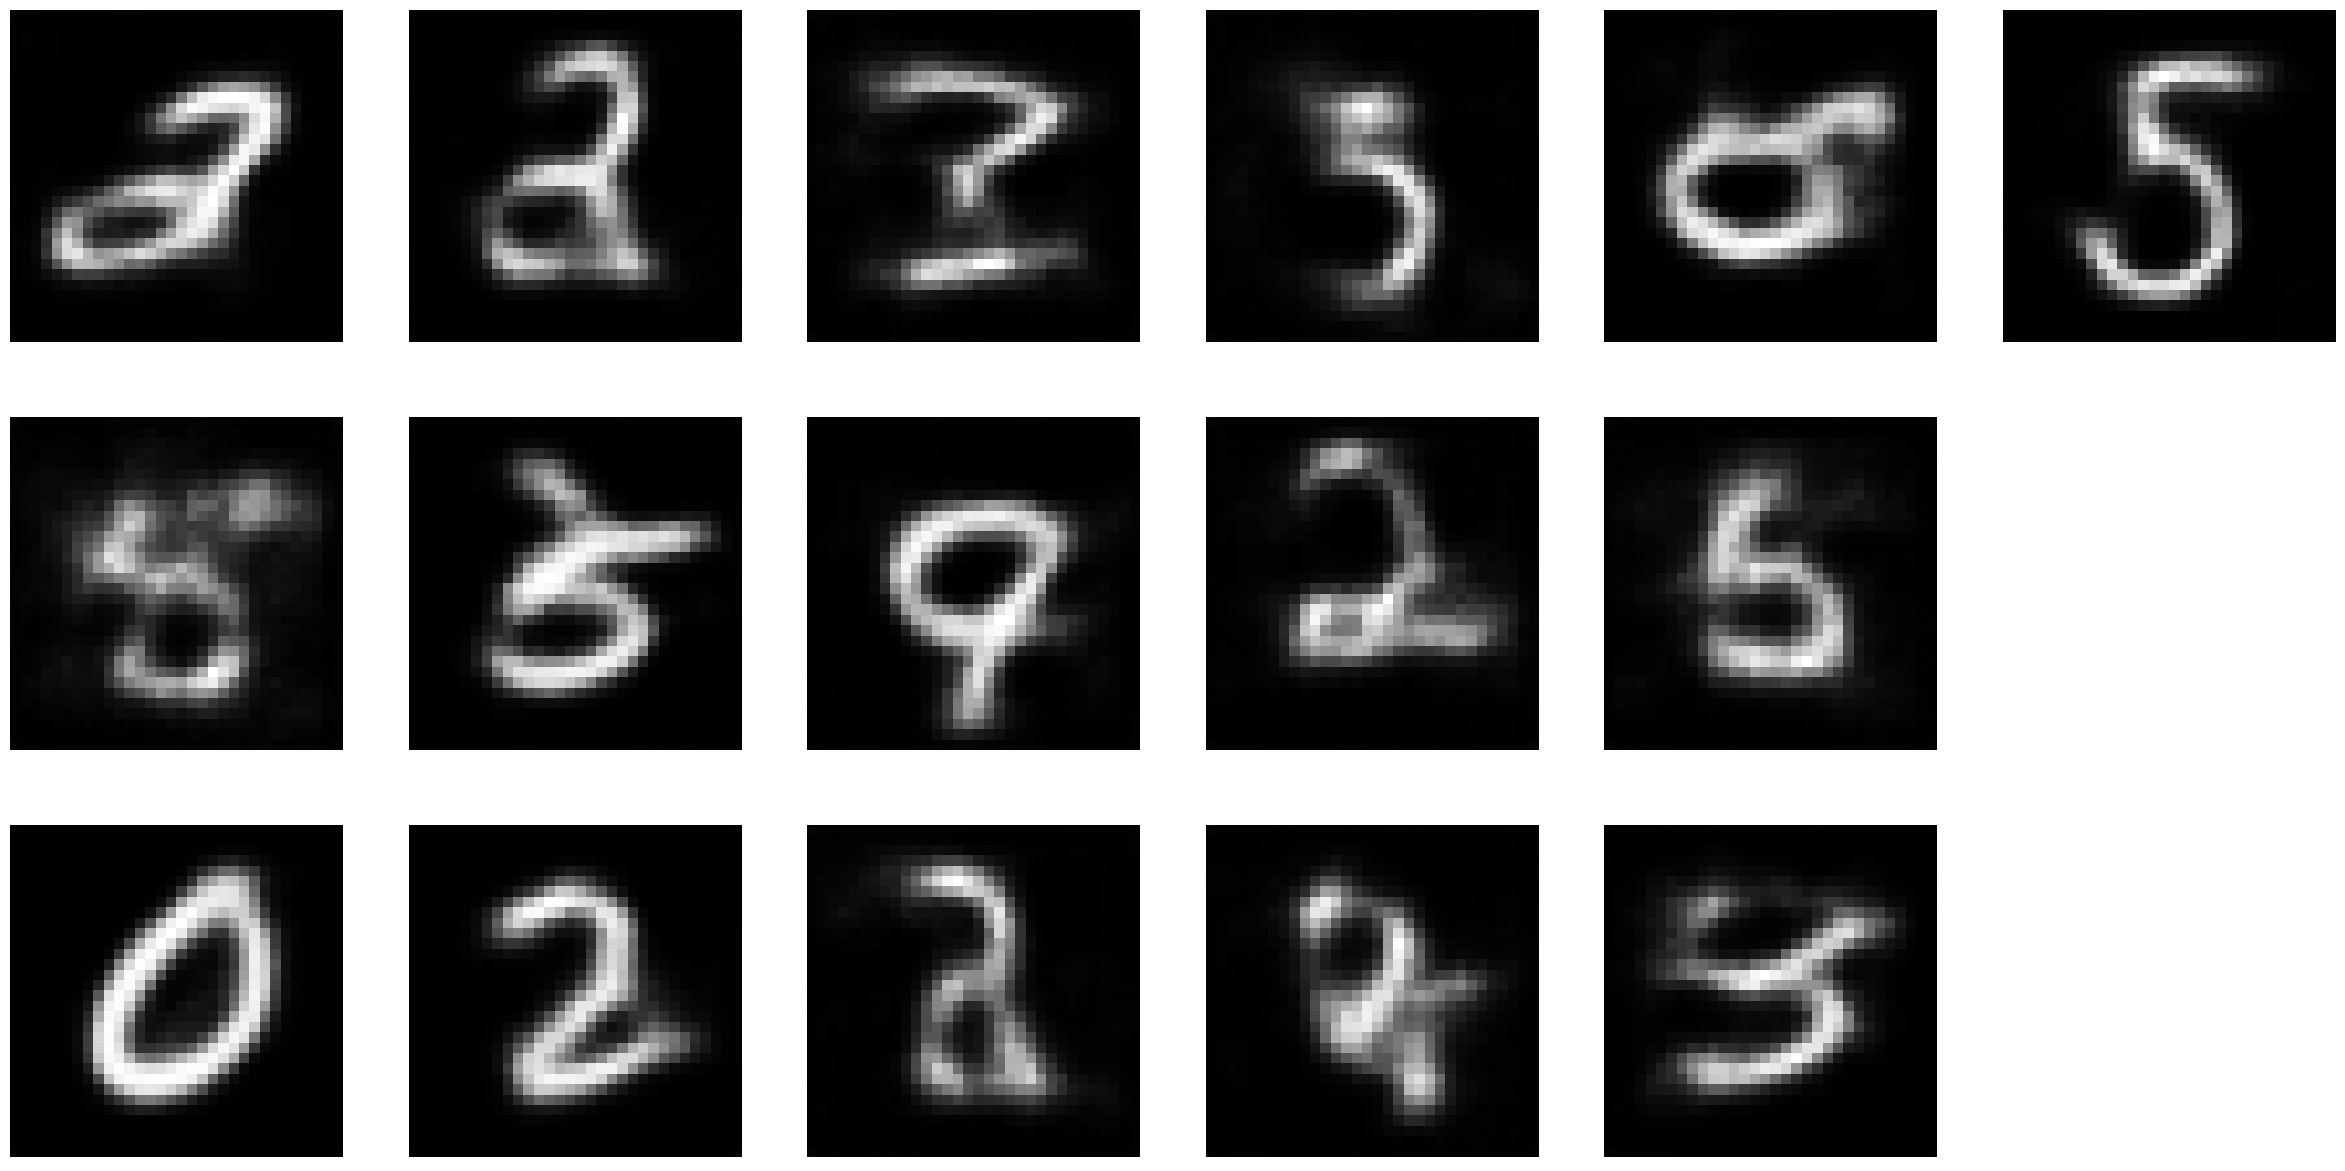

In [ ]:
# cluster #0
B = 16
z1_dim = enc.mu_z1_fc.out_channels
z2_dim = enc.z2_dim
K = enc.n_components
cluster_id = 0

with torch.no_grad():
    dec.eval()

    z1 = torch.randn(B, z1_dim, device=device)
    comp_mu = enc.z2_comp_mu(z1).view(B, K, z2_dim)
    comp_logvar = enc.z2_comp_var(z1).view(B, K, z2_dim)
    comp_sigma = torch.exp(comp_logvar)

    mu_k = comp_mu[:, cluster_id, :]
    sigma_k = comp_sigma[:, cluster_id, :]
    eps = torch.randn_like(mu_k)
    z2 = mu_k + sigma_k * eps

    z2_map = z2.view(B, z2_dim, 1, 1)
    generated = dec(z2_map)
    plotter(generated.cpu())

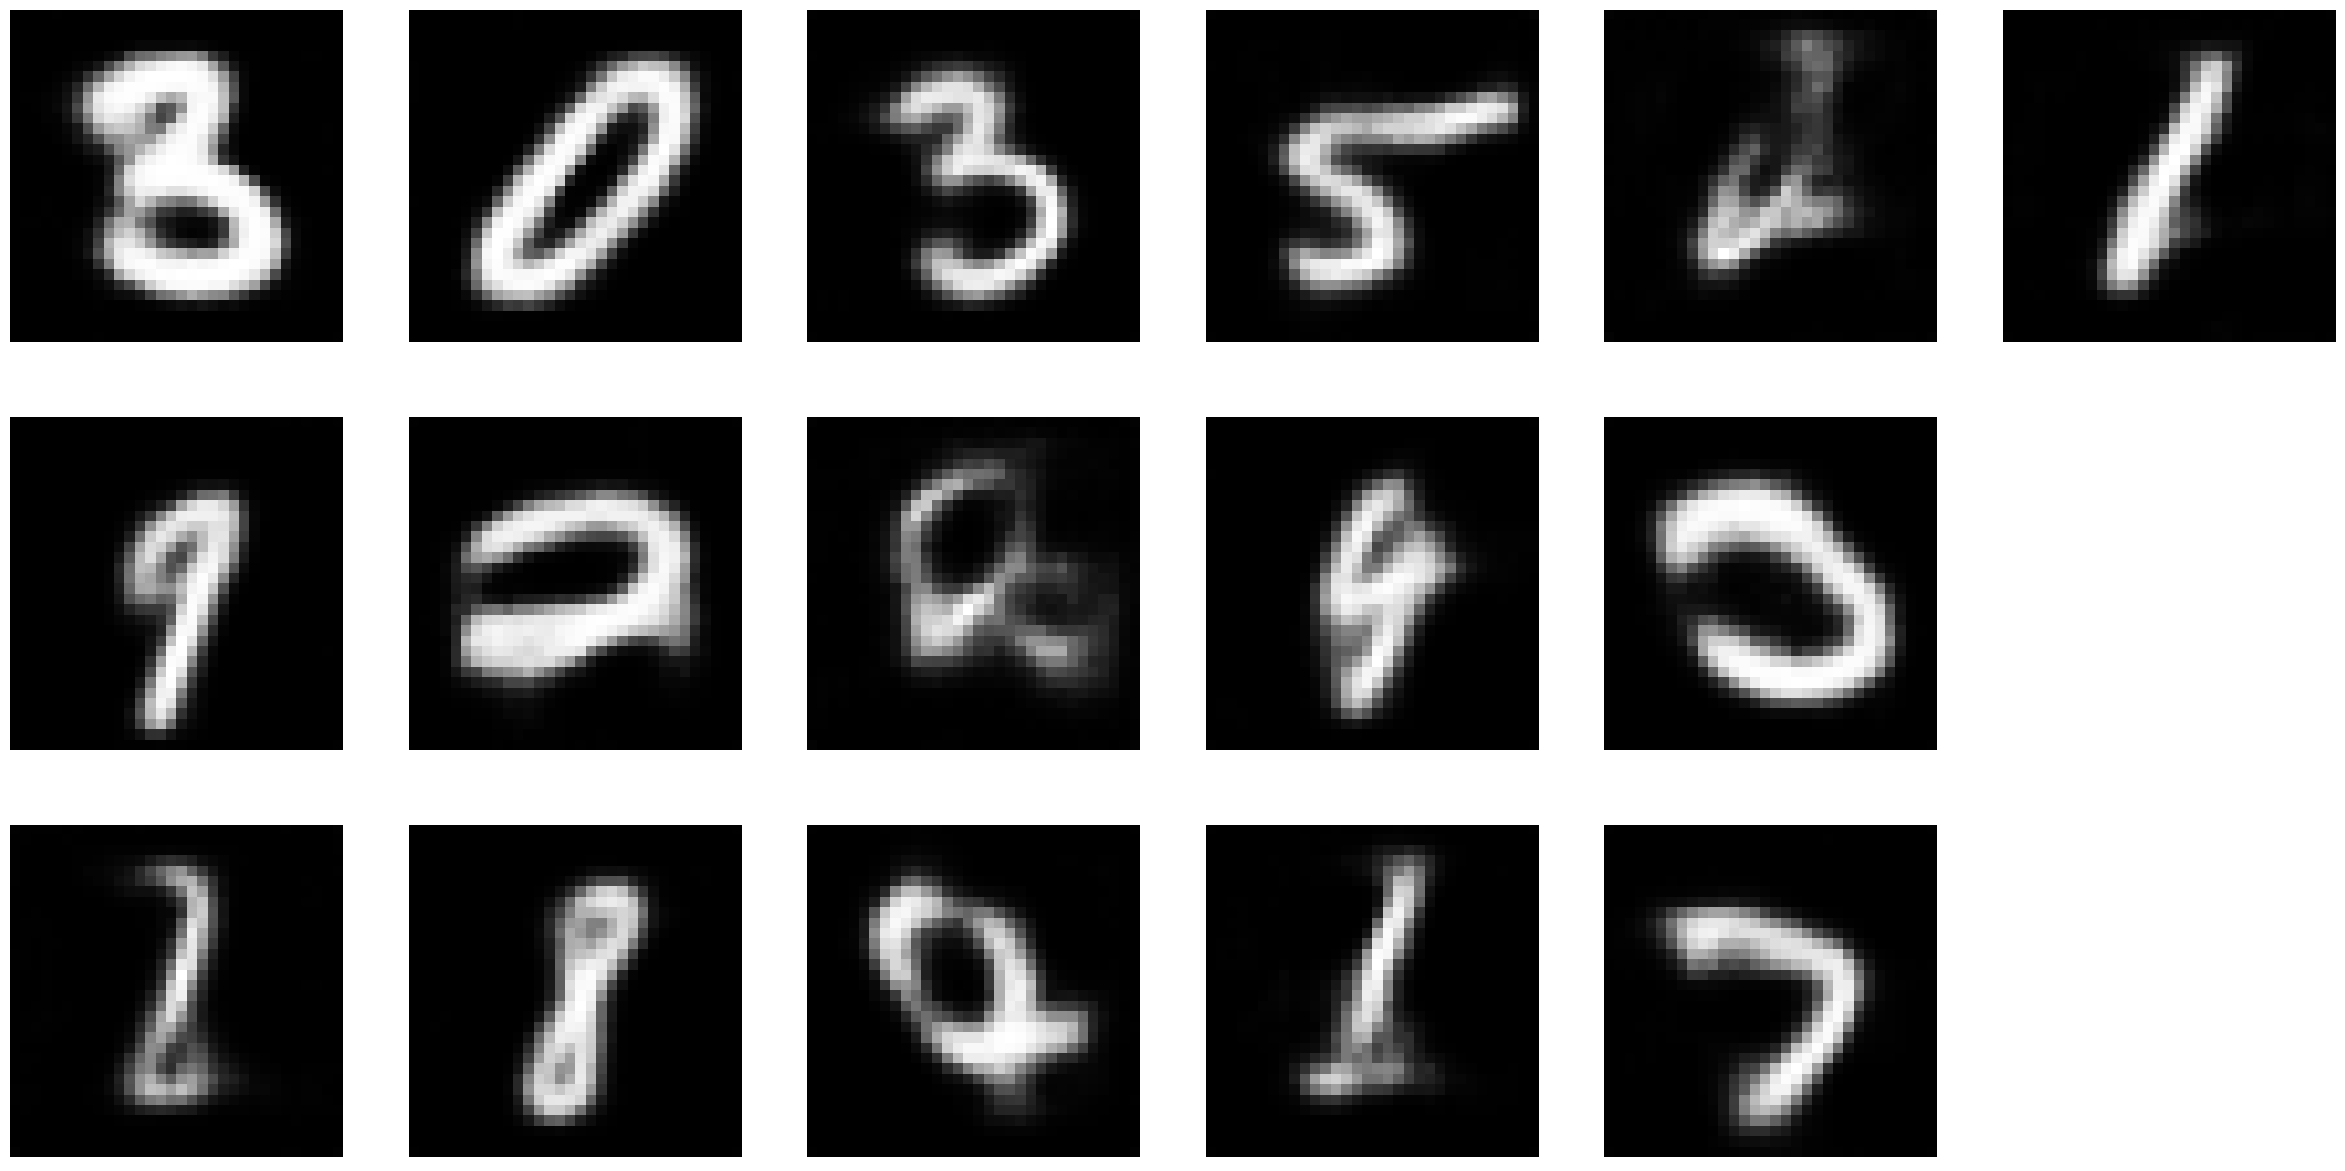

In [13]:
# cluster #1
B = 16
z1_dim = enc.mu_z1_fc.out_channels
z2_dim = enc.z2_dim
K = enc.n_components
cluster_id = 1

with torch.no_grad():
    dec.eval()

    z1 = torch.randn(B, z1_dim, device=device)
    comp_mu = enc.z2_comp_mu(z1).view(B, K, z2_dim)
    comp_logvar = enc.z2_comp_var(z1).view(B, K, z2_dim)
    comp_sigma = torch.exp(comp_logvar)

    mu_k = comp_mu[:, cluster_id, :]
    sigma_k = comp_sigma[:, cluster_id, :]
    eps = torch.randn_like(mu_k)
    z2 = mu_k + sigma_k * eps

    z2_map = z2.view(B, z2_dim, 1, 1)
    generated = dec(z2_map)
    plotter(generated.cpu())


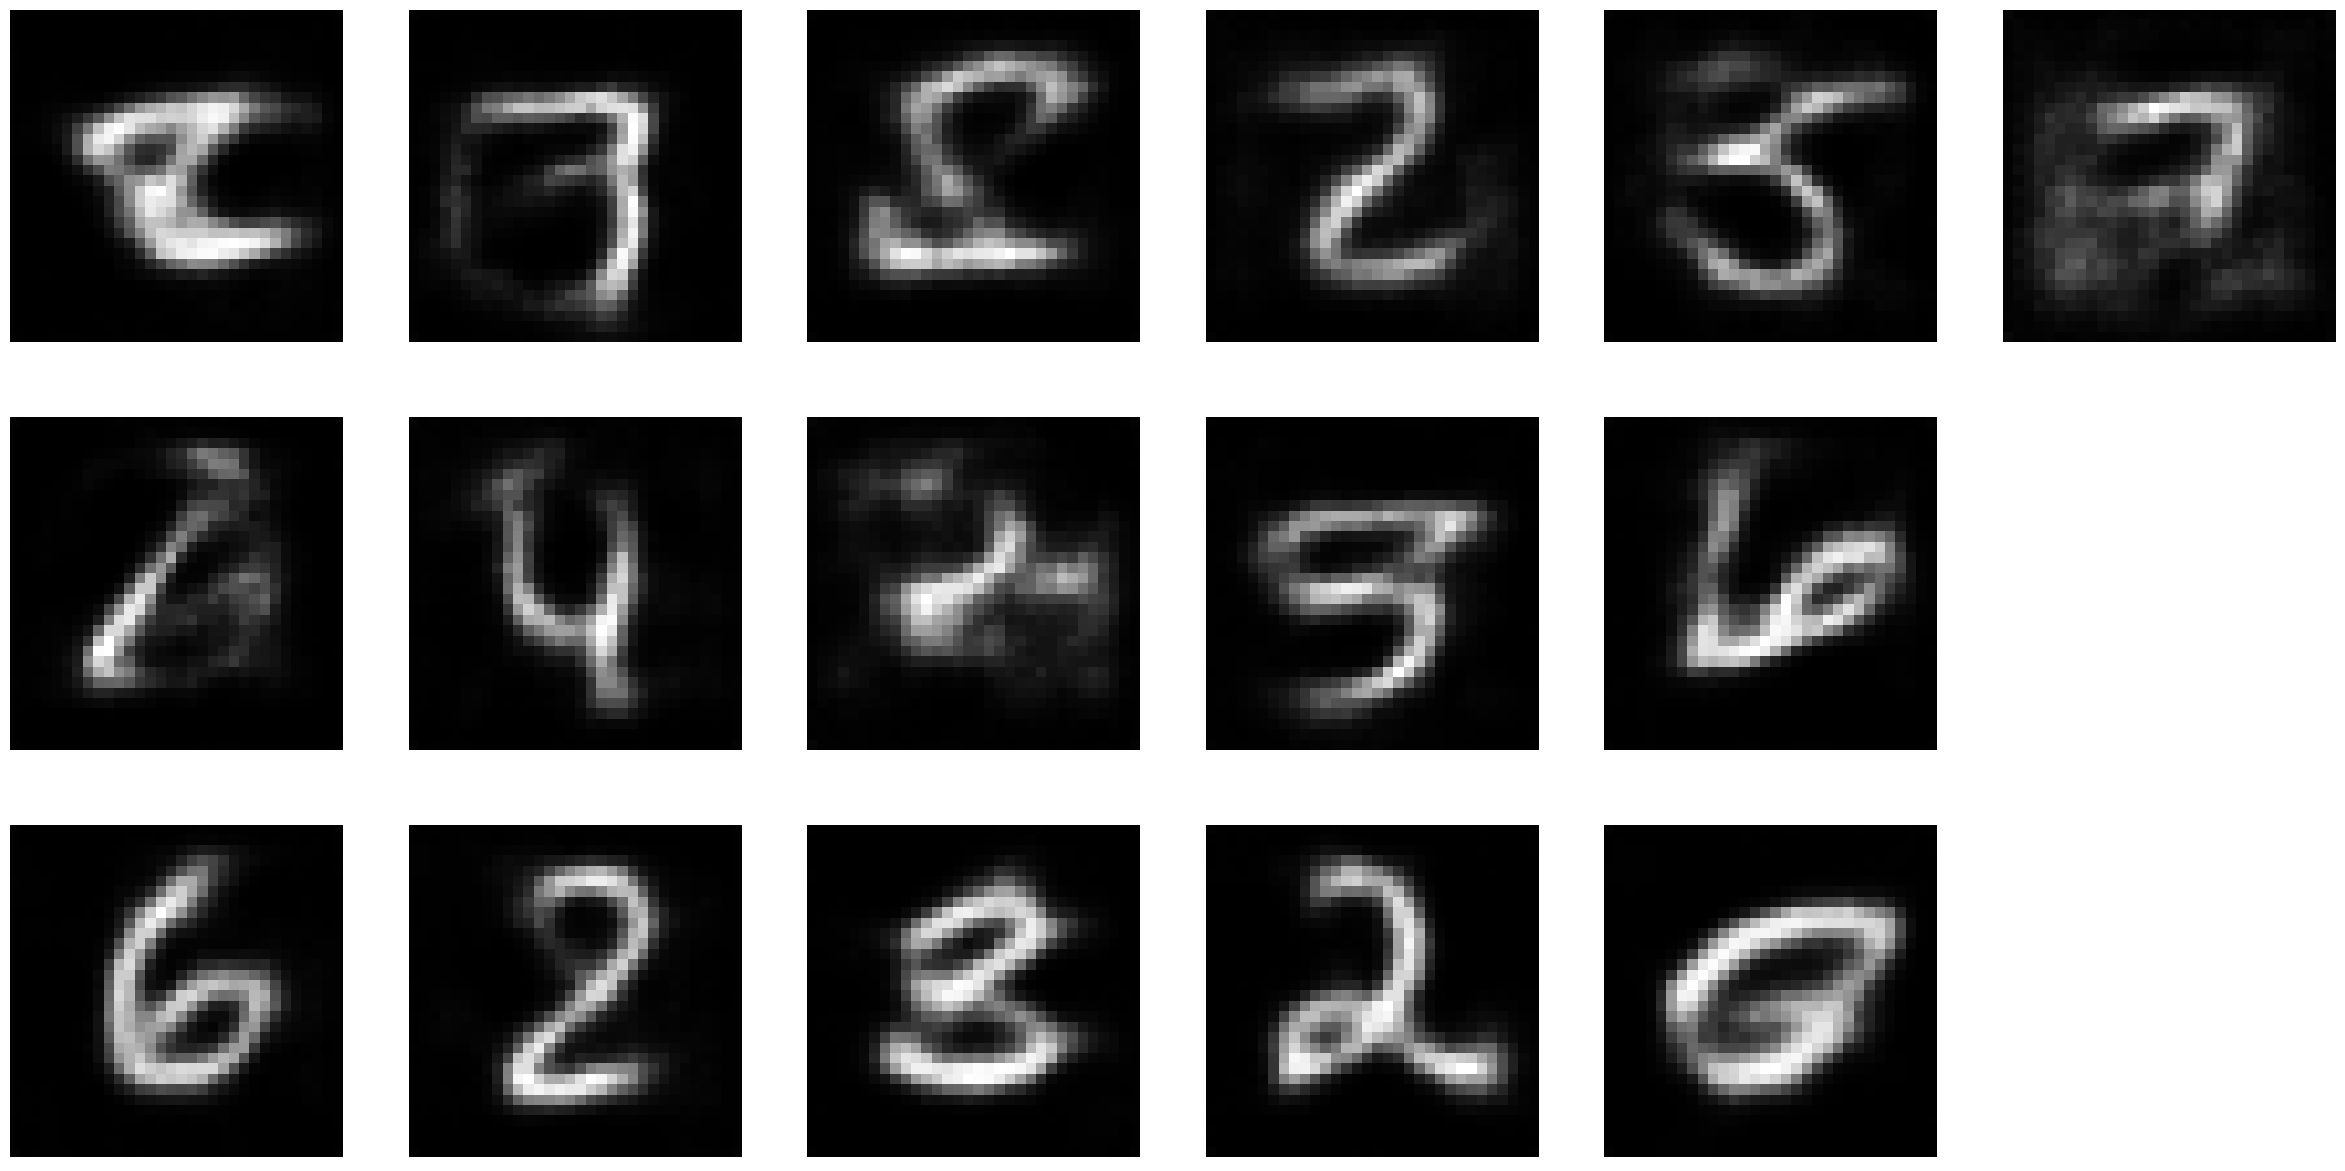

In [14]:
# cluster #2
B = 16
z1_dim = enc.mu_z1_fc.out_channels
z2_dim = enc.z2_dim
K = enc.n_components
cluster_id = 2

with torch.no_grad():
    dec.eval()

    z1 = torch.randn(B, z1_dim, device=device)
    comp_mu = enc.z2_comp_mu(z1).view(B, K, z2_dim)
    comp_logvar = enc.z2_comp_var(z1).view(B, K, z2_dim)
    comp_sigma = torch.exp(comp_logvar)

    mu_k = comp_mu[:, cluster_id, :]
    sigma_k = comp_sigma[:, cluster_id, :]
    eps = torch.randn_like(mu_k)
    z2 = mu_k + sigma_k * eps

    z2_map = z2.view(B, z2_dim, 1, 1)
    generated = dec(z2_map)
    plotter(generated.cpu())


While our results doesn't exhibit a clear separation of class as clearly as shown in the paper, we are able to generate style consistent images per cluster, as demonstrated above.